In [1]:
# import essential packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
import logging
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score


In [2]:
# setting seed
np.random.seed(0)
warnings.filterwarnings('ignore')

## 1. Brief Introduction of Data Set and Data Modelling Problem

The scope of this project aims to utilse and analyse surpervised machine learning techniques to predict IMDB movie ratings, based on predictor features related to directors, duration, movie title, actor names, facebook likes, country, genre etc. The target variable, imdb_score_binned, has 5 possible outcomes from 0 to 4, with 0 being the lowest score and 4 being the highest score. Classification-based machine learning models will be used in the analysis as we aim to assess the effectiveness of the machine learning models in categorising the movies into the distinct IMDB movie rating classes.

### 1.1 Importing Files

#### 1.1.1 Importing Dataset CSVs

In [3]:
# Importing the train dataset
train_dataset = pd.read_csv("train_dataset.csv")
# Importing the test dataset
test_dataset = pd.read_csv("test_dataset.csv")

# Check for null values in the 'language' column of train_dataset
null_values = train_dataset['language'].isnull().sum()

##### Feature Attributes: 
id - Unique row identification number \
plot_keywords - Keywords describing the plot of the movie \
title_embedding - Embedding vector for the movie title, generated using FastText 

##### Categorical Data
director_name - Name of the movie director (Categorical) \
actor_1_name - Name of the first listed actor (Categorical) \
actor_2_name - Name of the second listed actor (Categorical) \
actor_3_name - Name of the third listed actor (Categorical) \
genres - Genres of the movie (Categorical) \
movie_title- Title of the movie (Categorical) \
language - Language of the movie (Categorical) \
country - Country where the movie was produced (Categorical) \
content_rating - Content rating of the movie (Categorical) \
title_year - Year the movie was released (Categorical)

##### Numerical Data
num_critic_for_reviews - Number of critic reviews (Numerical) \
num_user_for_reviews - Number of user reviews (Numerical) \
num_voted_users - Number of users who voted for the movie (Numerical) \
facenumber_in_poster - Number of faces in the movie poster (Numerical) \
duration - Duration of the movie in minutes (Numerical) \
actor_1_facebook_likes - Number of Facebook likes for the first listed actor (Numerical) \
actor_2_facebook_likes - Number of Facebook likes for the second listed actor (Numerical) \
actor_3_facebook_likes - Number of Facebook likes for the third listed actor (Numerical) \
director_facebook_likes - Number of Facebook likes for the director (Numerical) \
cast_total_facebook_likes - Total number of Facebook likes for the entire cast (Numerical) \
movie_facebook_likes - Number of Facebook likes for the movie (Numerical) \
gross - Gross earnings of the movie (Numerical) \
average_degree_centrality - A measure of centrality for the movie in the network of movies based on shared actors (Numerical) 

##### Target Variable
imdb_score_binned - Binned IMDb score of the movie, used as the target variable for prediction (Categorical)


#### 1.1.2 Importing files containing CountVectorizer features for director names, actor names, and other text features for both training and test datasets

In [4]:
# Define the relative path to the directory containing the .npy files
directory = "features_countvec/features_countvec/"

# Load the .npy files
train_countvec_features_director_name = np.load(directory + "train_countvec_features_director_name.npy")
test_countvec_features_director_name = np.load(directory + "test_countvec_features_director_name.npy")

train_countvec_features_actor_1_name = np.load(directory + "train_countvec_features_actor_1_name.npy")
test_countvec_features_actor_1_name = np.load(directory + "test_countvec_features_actor_1_name.npy")

train_countvec_features_actor_2_name = np.load(directory + "train_countvec_features_actor_2_name.npy")
test_countvec_features_actor_2_name = np.load(directory + "test_countvec_features_actor_2_name.npy")

# Check the shapes
print(train_countvec_features_director_name.shape)
print(train_countvec_features_actor_1_name.shape)
print(train_countvec_features_actor_2_name.shape)

(3004, 2113)
(3004, 2063)
(3004, 2919)


For 
1. train_countvec_features_director_name / test_countvec_features_director_name (director_name), 
2. train_countvec_features_actor_1_name / test_countvec_features_actor_1_name (actor_1_name), 
3. train_countvec_features_actor_2_name / test_countvec_features_actor_2_name (actor_2_name),

each respective numpy array containing the CountVectorizer features:

- columns represent the unique words
- rows represent the number of rows of data/director names
- the number in each cell represents the count of the word in the particular text

It is worth noting that actor_3_name has not been vectorised, hence this is something that we can look into in the pre-processing step.

#### 1.1.3 Importing files containing Doc2Vec features for plot keywords, genres, and other text features for both training and test datasets

In [5]:
# Define the relative path to the directory containing the .npy files
directory = "features_doc2vec/features_doc2vec/"

# Load the .npy files
train_doc2vec_features_plot_keywords = np.load(directory + "train_doc2vec_features_plot_keywords.npy")
test_doc2vec_features_plot_keywords = np.load(directory + "test_doc2vec_features_plot_keywords.npy")

train_doc2vec_features_genre = np.load(directory + "train_doc2vec_features_genre.npy")
test_doc2vec_features_genre = np.load(directory + "test_doc2vec_features_genre.npy")

# Check the shape
print(train_doc2vec_features_plot_keywords.shape)
print(train_doc2vec_features_genre.shape)

(3004, 100)
(3004, 100)


For
train_doc2vec_features_plot_keywords / test_doc2vec_features_plot_keywords (plot_keywords),
train_doc2vec_features_genre / test_doc2vec_features_genre (genres),

each respective numpy array containing the Doc2Vec features the Doc2Vec representations of the textual content:

- each row in the numpy array corresponds to a document
- each column represents a dimension in the vector space

Doc2Vec features capture the semantic meanings of the text, enabling downstream tasks to be performed using numerical representations of the text.

#### 1.1.4 Importing files containing FastText embeddings for movie titles for both training and test datasets

In [6]:
# Define the relative path to the directory containing the .npy files
directory = "features_fasttext/features_fasttext/"

# Load the .npy files
train_fasttext_title_embeddings = np.load(directory + "train_fasttext_title_embeddings.npy")
test_fasttext_title_embeddings = np.load(directory + "test_fasttext_title_embeddings.npy")

# Check the shape of train_fasttext_title_embeddings
train_fasttext_title_embeddings.shape


(3004, 100)

For
train_fasttext_title_embeddings / test_fasttext_title_embeddings (movie_title):

each respective numpy array containing the FastText features the FastText representations of the textual content:

FastText is an extension of Word2Vec, can capture sub-word information and is useful for measuring similarity or prediction of movie success based on title semantics.

## 2. Exploratory Data Analysis

### 2.1 Examining Target Variable 

Before performing initial investigations on the dataset to discover patterns and spot inconsistencies/anomalies in the data, we will first take a look at the target variable, imdb_score_binned, in *train_dataset*.

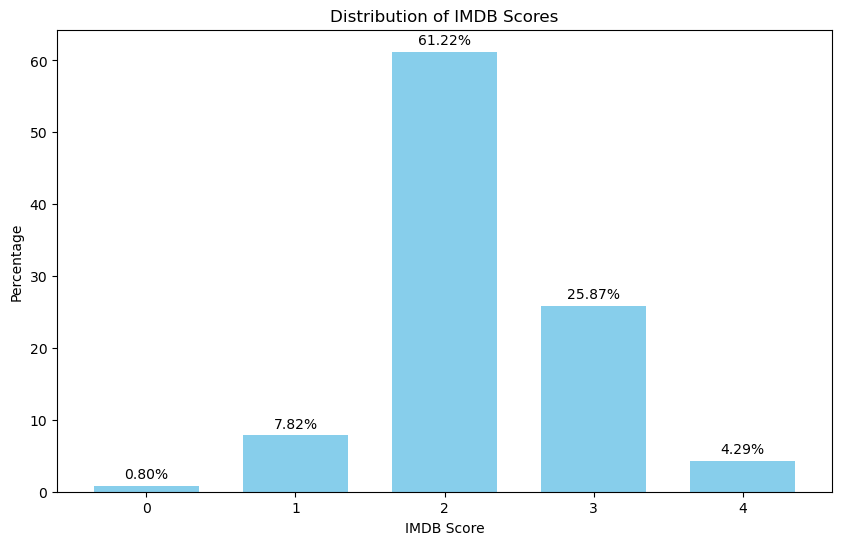

In [7]:
# Calculate the percentage of each category
percentage_values = train_dataset['imdb_score_binned'].value_counts(normalize=True) * 100
percentage_values = percentage_values.reindex(index=[0, 1, 2, 3, 4])

# Create the bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size
ax = percentage_values.plot(kind='bar', color='skyblue', width=0.7) 
plt.title('Distribution of IMDB Scores')
plt.xlabel('IMDB Score')
plt.ylabel('Percentage')
plt.xticks(rotation=0, color='black') 
plt.yticks(color='black') 

# Display percentage values on the bars
for i, value in enumerate(percentage_values):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', color='black')

plt.show()


From the bar plot of our target variable, imdb_score_binned, we can see that the distribution is significantly imbalanced, with imdb_score_binned = 2 and imdb_score_binned = 3 taking up more than 85% of the total number of samples. This is something that we should look into later in this report, as a class balance may pose a challenge to machine learning models, where the majority classes are overrepresented while the minority classes are underrepresented, and may cause models to struggle to effectively learn patterns from minority classes and lead to biased predictions and reduced model performance. (Peebles, 2022)

### 2.2 Examining Attributes In Relation To Target Variable

In this section, we will examine the feature attributes in our train set to see which attributes are closely tied to the target variable, which will allow us to determine the important features for our predictors.

#### 2.2.1 Categorical Feature Analysis

Categorical Features:
director_name, actor_1_name, actor_2_name, actor_3_name, genres, movie_title, language, country, content_rating, title_year 

In this section, we will be using exploratory data analysis to see which categorical variables are closely tied to the mean imdb_score_binned rating.

*x-axis labels were removed for some charts which large numbers of categories to enhance the readability of the visualisation

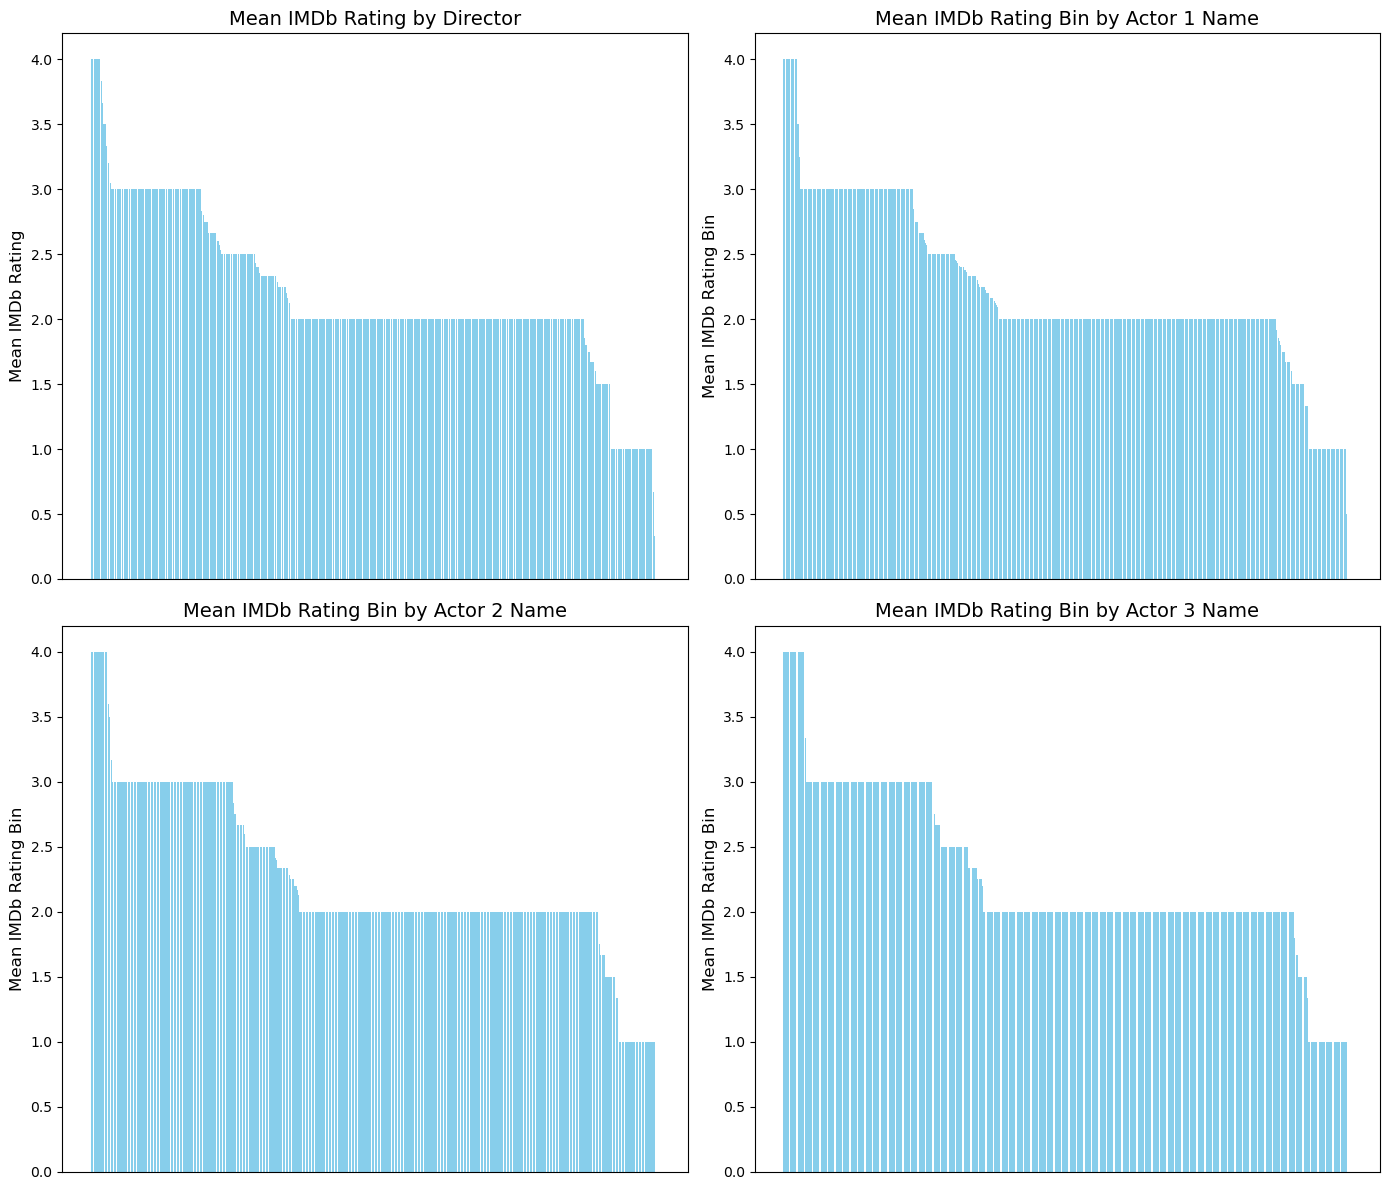

In [8]:
plt.figure(figsize=(14, 12))

# Group by director_name and calculate the mean IMDb rating for each director
director_ratings = train_dataset.groupby('director_name')['imdb_score_binned'].mean().reset_index()
director_ratings_sorted = director_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(2, 2, 1)
plt.bar(director_ratings_sorted['director_name'], director_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.ylabel('Mean IMDb Rating', fontsize=12)
plt.title('Mean IMDb Rating by Director', fontsize=14)
plt.xticks([])  # Remove x-axis labels

# Group by actor_1_name and calculate the mean IMDb rating bin for each actor
actor_ratings = train_dataset.groupby('actor_1_name')['imdb_score_binned'].mean().reset_index()
actor_ratings_sorted = actor_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(2, 2, 2)
plt.bar(actor_ratings_sorted['actor_1_name'], actor_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.ylabel('Mean IMDb Rating Bin', fontsize=12)
plt.title('Mean IMDb Rating Bin by Actor 1 Name', fontsize=14)
plt.xticks([])  # Remove x-axis labels

# Group by actor_2_name and calculate the mean IMDb rating bin for each actor
actor_ratings = train_dataset.groupby('actor_2_name')['imdb_score_binned'].mean().reset_index()
actor_ratings_sorted = actor_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(2, 2, 3)
plt.bar(actor_ratings_sorted['actor_2_name'], actor_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.ylabel('Mean IMDb Rating Bin', fontsize=12)
plt.title('Mean IMDb Rating Bin by Actor 2 Name', fontsize=14)
plt.xticks([])  # Remove x-axis labels

# Group by actor_3_name and calculate the mean IMDb rating bin for each actor
actor_ratings = train_dataset.groupby('actor_3_name')['imdb_score_binned'].mean().reset_index()
actor_ratings_sorted = actor_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(2, 2, 4)
plt.bar(actor_ratings_sorted['actor_3_name'], actor_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.ylabel('Mean IMDb Rating Bin', fontsize=12)
plt.title('Mean IMDb Rating Bin by Actor 3 Name', fontsize=14)
plt.xticks([])  # Remove x-axis labels

plt.tight_layout()
plt.show()


Beginning with director_name, actor_1_name, actor_2_name, and actor_3_name, we investigated the mean IMDb rating of movies associated with each individual. This initial exploration allowed us to uncover patterns in movie ratings based on the involvement of specific directors and actors. The bar plots shows a variable distribution of the abovementioned factors with respect to mean IMDB rating, hence we can keep these 4 factors in our model.


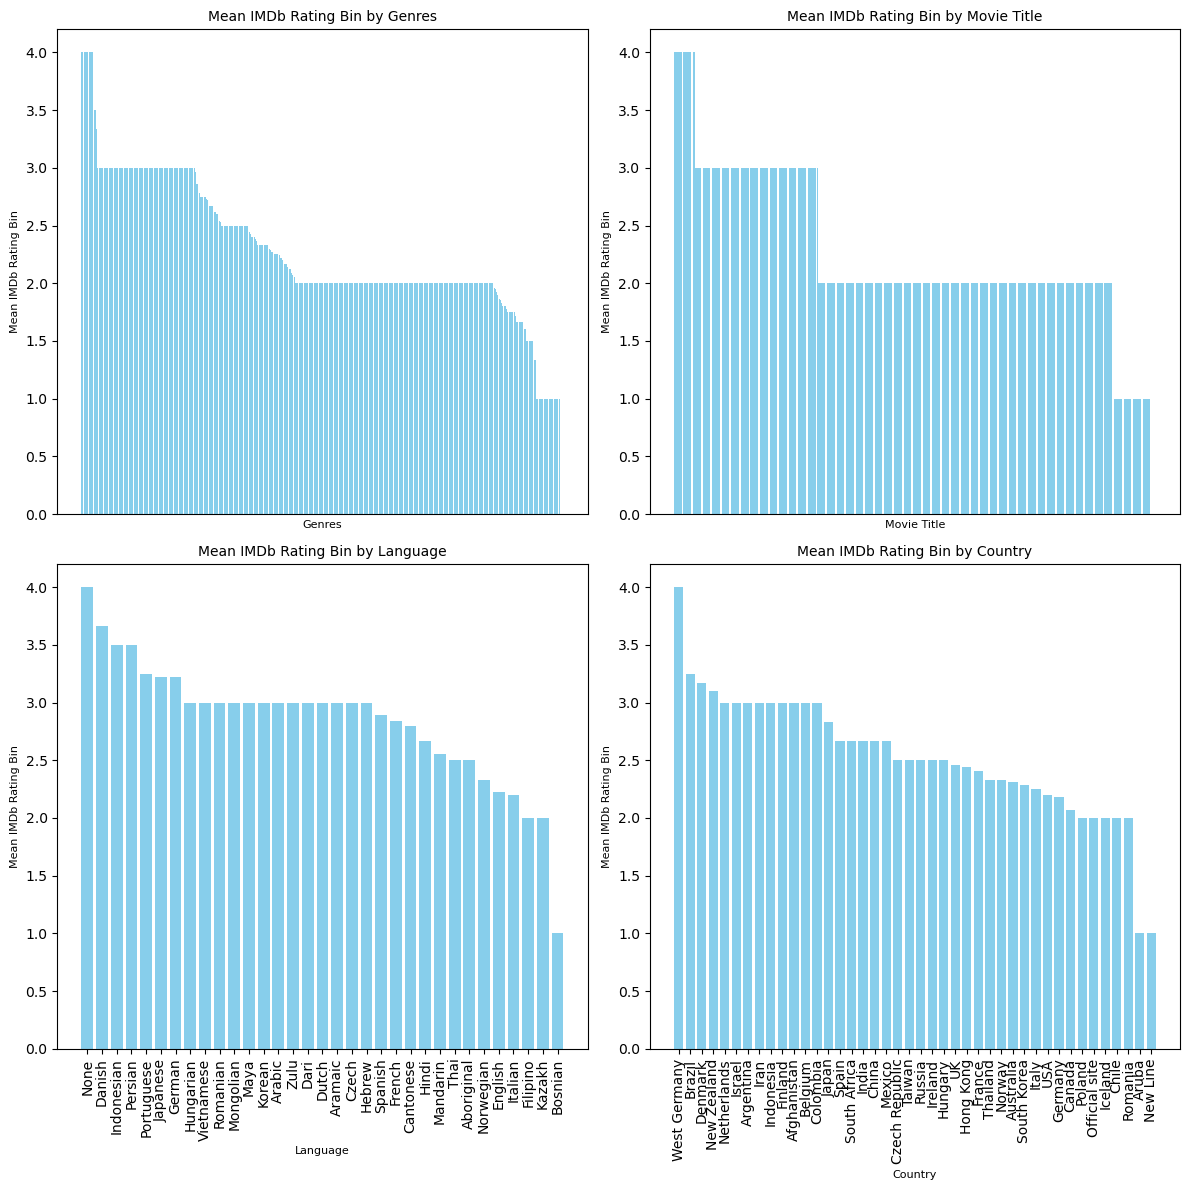

In [9]:
plt.figure(figsize=(12, 12))

# Plotting the bar chart for genres
genre_ratings = train_dataset.groupby('genres')['imdb_score_binned'].mean().reset_index()
genre_ratings_sorted = genre_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(2, 2, 1)
plt.bar(genre_ratings_sorted['genres'], genre_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.xlabel('Genres', fontsize=8)
plt.ylabel('Mean IMDb Rating Bin', fontsize=8)
plt.title('Mean IMDb Rating Bin by Genres', fontsize=10)
plt.xticks([])  # Remove x-axis labels

# Plotting the bar chart for movie titles
title_ratings = train_dataset.groupby('movie_title')['imdb_score_binned'].mean().reset_index()
title_ratings_sorted = title_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(2, 2, 2)
plt.bar(title_ratings_sorted['movie_title'], title_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.xlabel('Movie Title', fontsize=8)
plt.ylabel('Mean IMDb Rating Bin', fontsize=8)
plt.title('Mean IMDb Rating Bin by Movie Title', fontsize=10)
plt.xticks([])  # Remove x-axis labels

# Plotting the bar chart for languages
language_ratings = train_dataset.groupby('language')['imdb_score_binned'].mean().reset_index()
language_ratings_sorted = language_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(2, 2, 3)
plt.bar(language_ratings_sorted['language'], language_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.xlabel('Language', fontsize=8)
plt.ylabel('Mean IMDb Rating Bin', fontsize=8)
plt.title('Mean IMDb Rating Bin by Language', fontsize=10)
plt.xticks(rotation=90)  # Rotate x-axis labels

# Plotting the bar chart for countries
country_ratings = train_dataset.groupby('country')['imdb_score_binned'].mean().reset_index()
country_ratings_sorted = country_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(2, 2, 4)
plt.bar(country_ratings_sorted['country'], country_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.xlabel('Country', fontsize=8)
plt.ylabel('Mean IMDb Rating Bin', fontsize=8)
plt.title('Mean IMDb Rating Bin by Country', fontsize=10)
plt.xticks(rotation=90)  # Rotate x-axis labels

plt.tight_layout()
plt.show()


Next, we look at  genres, movie_title, language, country, and investigated the mean IMDb rating of movies associated with each factor. The bar plots shows a variable distribution of the abovementioned factors with respect to mean IMDB rating, hence we can keep these 4 factors in our model as they can be valuable features to include in our predictive model. 

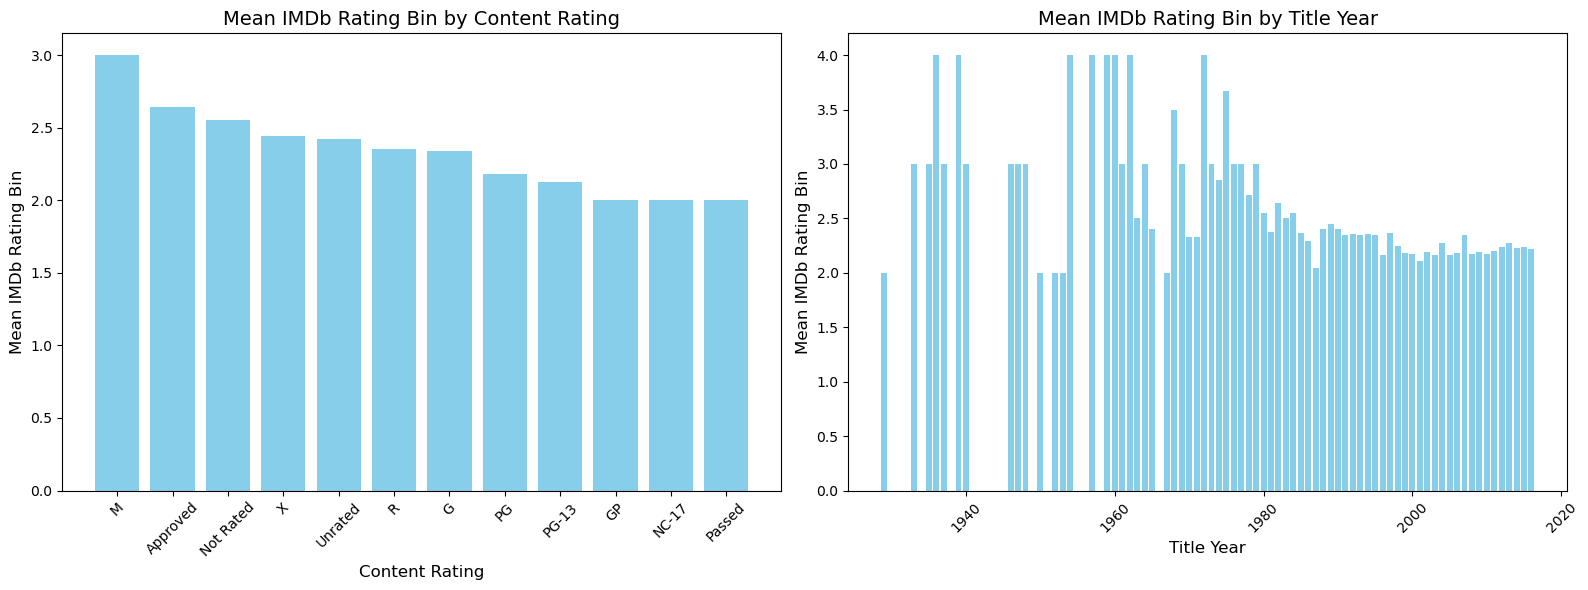

In [10]:
plt.figure(figsize=(16, 6))

# Plotting the bar chart for content ratings
content_ratings = train_dataset.groupby('content_rating')['imdb_score_binned'].mean().reset_index()
content_ratings_sorted = content_ratings.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(1, 2, 1)
plt.bar(content_ratings_sorted['content_rating'], content_ratings_sorted['imdb_score_binned'], color='skyblue')
plt.xlabel('Content Rating', fontsize=12)
plt.ylabel('Mean IMDb Rating Bin', fontsize=12)
plt.title('Mean IMDb Rating Bin by Content Rating', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Plotting the bar chart for title years
title_years = train_dataset.groupby('title_year')['imdb_score_binned'].mean().reset_index()
title_years_sorted = title_years.sort_values(by='imdb_score_binned', ascending=False)
plt.subplot(1, 2, 2)
plt.bar(title_years_sorted['title_year'], title_years_sorted['imdb_score_binned'], color='skyblue')
plt.xlabel('Title Year', fontsize=12)
plt.ylabel('Mean IMDb Rating Bin', fontsize=12)
plt.title('Mean IMDb Rating Bin by Title Year', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()


Finally, we look at content_rating, title_year to further elucidate factors influencing IMDb ratings across different movie characteristics. These 2 factors also show a variable distribution, hence by retaining these 2 factors in our model, we aim to capture the nuanced influences they have on movie ratings.

In [11]:
# Create a DataFrame with the number of unique categories for each variable
unique_categories_data = {
    "Variable": ["Director Name", "Actor 1 Name", "Actor 2 Name", "Actor 3 Name", "Genres", 
                 "Movie Title", "Language", "Country", "Content Rating", "Title Year"],
    "Number of Unique Categories": [
        train_dataset['director_name'].nunique(),
        train_dataset['actor_1_name'].nunique(),
        train_dataset['actor_2_name'].nunique(),
        train_dataset['actor_3_name'].nunique(),
        train_dataset['genres'].nunique(),
        train_dataset['movie_title'].nunique(),
        train_dataset['language'].nunique(),
        train_dataset['country'].nunique(),
        train_dataset['content_rating'].nunique(),
        train_dataset['title_year'].nunique()
    ]
}

# Create a DataFrame
unique_categories_df = pd.DataFrame(unique_categories_data)

# Print the DataFrame
print(unique_categories_df)


         Variable  Number of Unique Categories
0   Director Name                         1460
1    Actor 1 Name                         1265
2    Actor 2 Name                         1903
3    Actor 3 Name                         2198
4          Genres                          675
5     Movie Title                         2942
6        Language                           33
7         Country                           42
8  Content Rating                           12
9      Title Year                           72


During the exploratory data analysis of the categorical variables using the bar plots above, some features were also found to have a large number of unique categories. Therefore, we decided to perform further investigation into the number of unique categories that each feature has, as seen in the table. This is something to take note of during the pre-processing steps later as a large number of categories may lead to a large dimensionality, thereby influencing the efficacy of our analytical models.

#### 2.2.2 Checking For Outliers (Numerical Variables)

Numerical Variables: 

num_critic_for_reviews, num_user_for_reviews, num_voted_users, facenumber_in_poster, 
actor_1_facebook_likes, actor_2_facebook_likes, actor_3_facebook_likes, director_facebook_likes, cast_total_facebook_likes, movie_facebook_likes,
duration, gross, average_degree_centrality


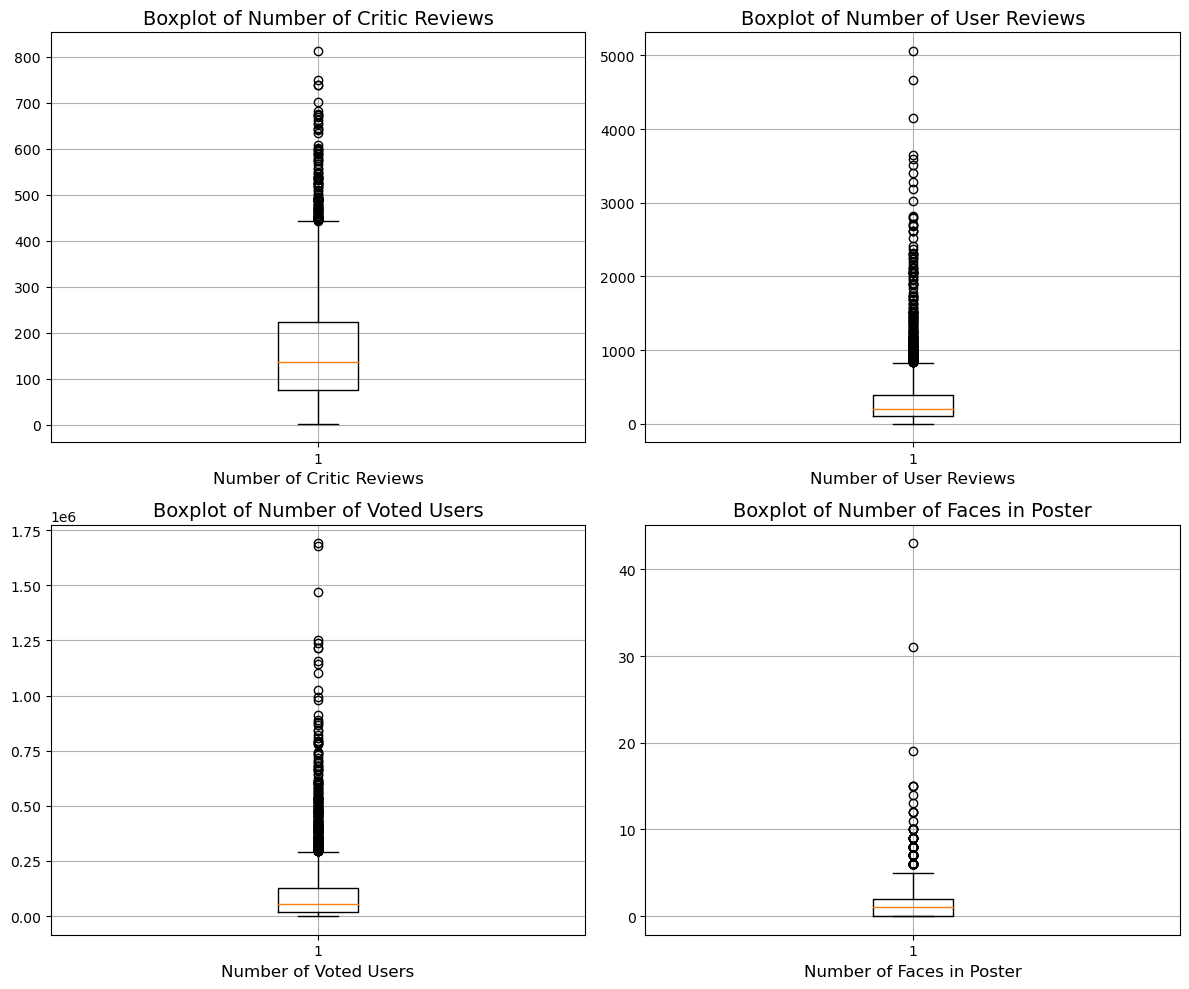

In [12]:
# Creating a 2x2 subplot layout
plt.figure(figsize=(12, 10))

# Plotting the boxplot for num_critic_for_reviews
plt.subplot(2, 2, 1)
plt.boxplot(train_dataset['num_critic_for_reviews'])
plt.xlabel('Number of Critic Reviews', fontsize=12)
plt.title('Boxplot of Number of Critic Reviews', fontsize=14)
plt.grid(True)

# Plotting boxplot for num_user_for_reviews
plt.subplot(2, 2, 2)
plt.boxplot(train_dataset['num_user_for_reviews'])
plt.xlabel('Number of User Reviews', fontsize=12)
plt.title('Boxplot of Number of User Reviews', fontsize=14)
plt.grid(True)

# Plotting boxplot for num_voted_users
plt.subplot(2, 2, 3)
plt.boxplot(train_dataset['num_voted_users'])
plt.xlabel('Number of Voted Users', fontsize=12)
plt.title('Boxplot of Number of Voted Users', fontsize=14)
plt.grid(True)

# Plotting boxplot for facenumber_in_poster
plt.subplot(2, 2, 4)
plt.boxplot(train_dataset['facenumber_in_poster'])
plt.xlabel('Number of Faces in Poster', fontsize=12)
plt.title('Boxplot of Number of Faces in Poster', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


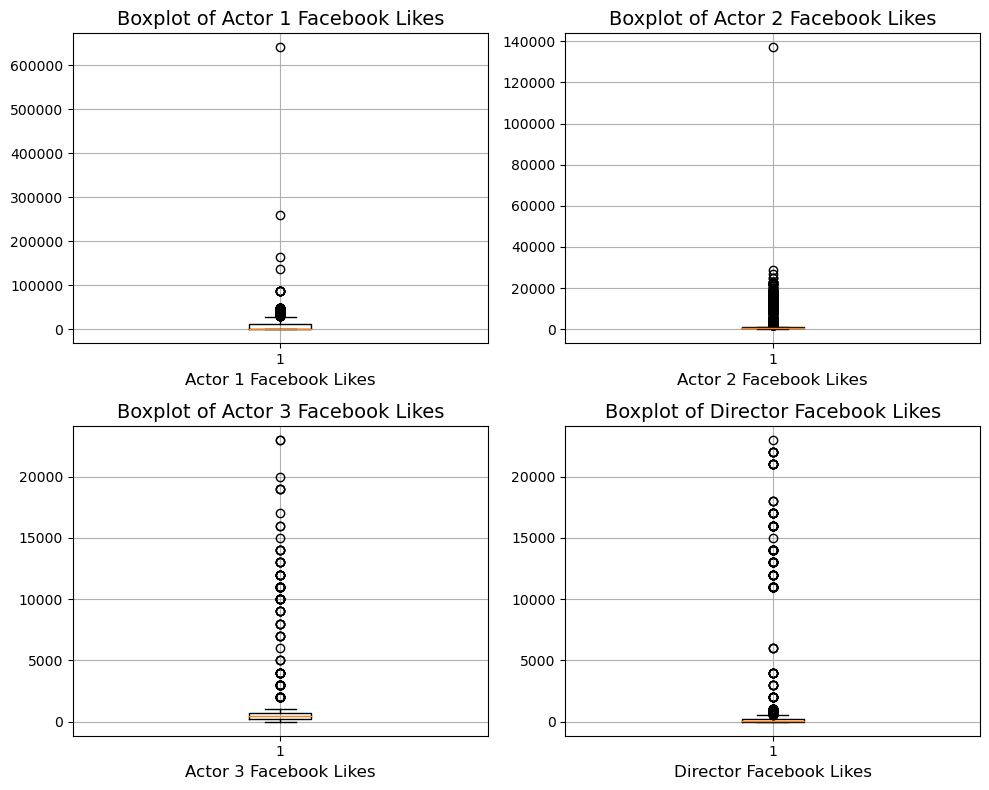

In [13]:
# Plotting boxplot for actor_1_facebook_likes
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.boxplot(train_dataset['actor_1_facebook_likes'])
plt.xlabel('Actor 1 Facebook Likes', fontsize=12)
plt.title('Boxplot of Actor 1 Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting boxplot for actor_2_facebook_likes
plt.subplot(2, 2, 2)
plt.boxplot(train_dataset['actor_2_facebook_likes'])
plt.xlabel('Actor 2 Facebook Likes', fontsize=12)
plt.title('Boxplot of Actor 2 Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting boxplot for actor_3_facebook_likes
plt.subplot(2, 2, 3)
plt.boxplot(train_dataset['actor_3_facebook_likes'])
plt.xlabel('Actor 3 Facebook Likes', fontsize=12)
plt.title('Boxplot of Actor 3 Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting boxplot for director_facebook_likes
plt.subplot(2, 2, 4)
plt.boxplot(train_dataset['director_facebook_likes'])
plt.xlabel('Director Facebook Likes', fontsize=12)
plt.title('Boxplot of Director Facebook Likes', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


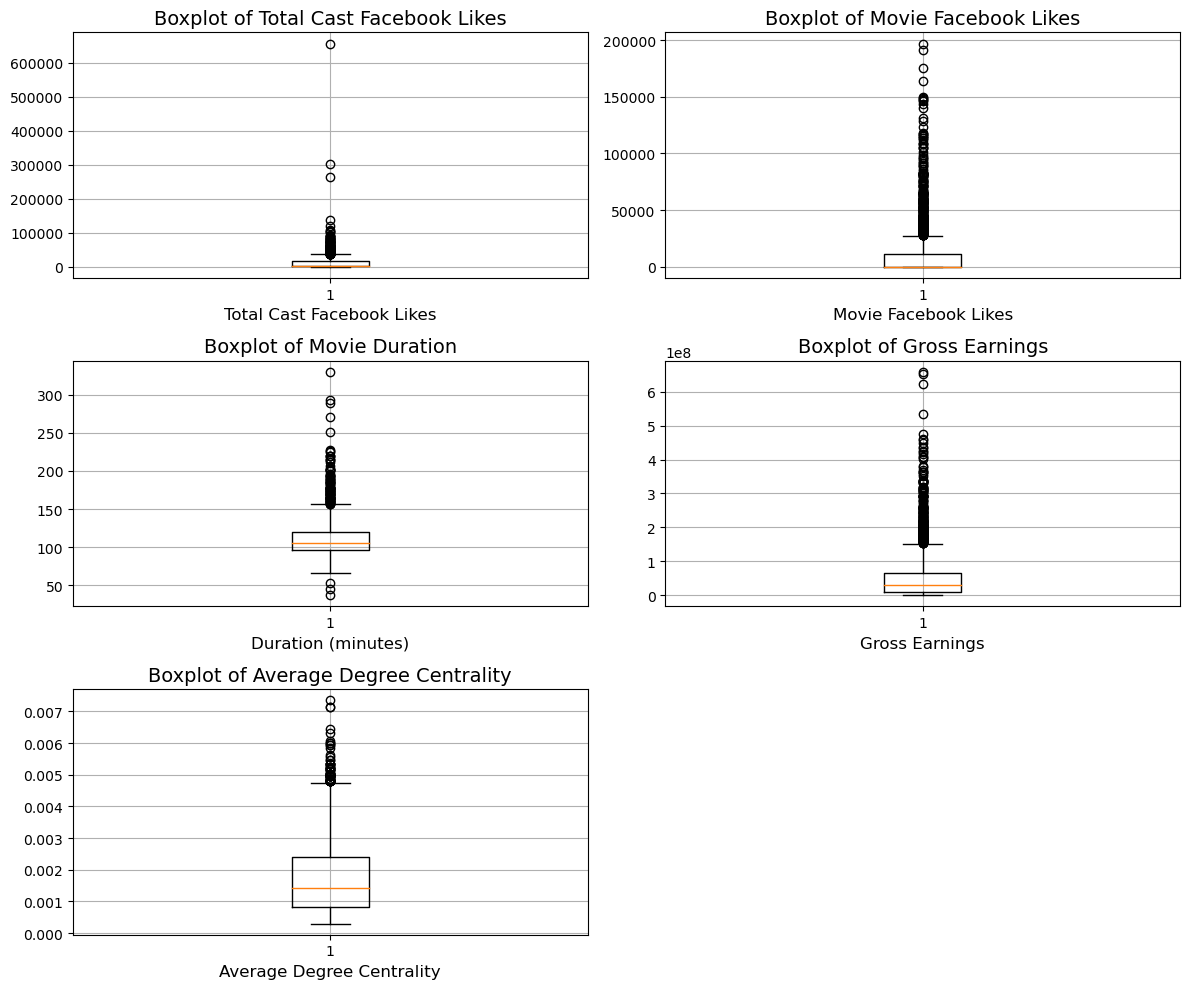

In [14]:
# Plotting boxplot for cast_total_facebook_likes
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.boxplot(train_dataset['cast_total_facebook_likes'])
plt.xlabel('Total Cast Facebook Likes', fontsize=12)
plt.title('Boxplot of Total Cast Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting boxplot for movie_facebook_likes
plt.subplot(3, 2, 2)
plt.boxplot(train_dataset['movie_facebook_likes'])
plt.xlabel('Movie Facebook Likes', fontsize=12)
plt.title('Boxplot of Movie Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting boxplot for duration
plt.subplot(3, 2, 3)
plt.boxplot(train_dataset['duration'])
plt.xlabel('Duration (minutes)', fontsize=12)
plt.title('Boxplot of Movie Duration', fontsize=14)
plt.grid(True)

# Plotting boxplot for gross earnings
plt.subplot(3, 2, 4)
plt.boxplot(train_dataset['gross'])
plt.xlabel('Gross Earnings', fontsize=12)
plt.title('Boxplot of Gross Earnings', fontsize=14)
plt.grid(True)

# Plotting boxplot for average_degree_centrality
plt.subplot(3, 2, 5)
plt.boxplot(train_dataset['average_degree_centrality'])
plt.xlabel('Average Degree Centrality', fontsize=12)
plt.title('Boxplot of Average Degree Centrality', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


From the boxplots of all the numerical variables, we can see that there is quite a signifiant number of outliers (outside the interquartile range) present in the numerical variables in the dataset. However, removing such a large number of data points which can contain valuable information for our machine learning models may not be feasible, and we also do not have enough concrete evidence that these data points are actually anomalous observations. To understand this better, we will be plotting the histograms of the respective features to better understand the distribution of each feature.

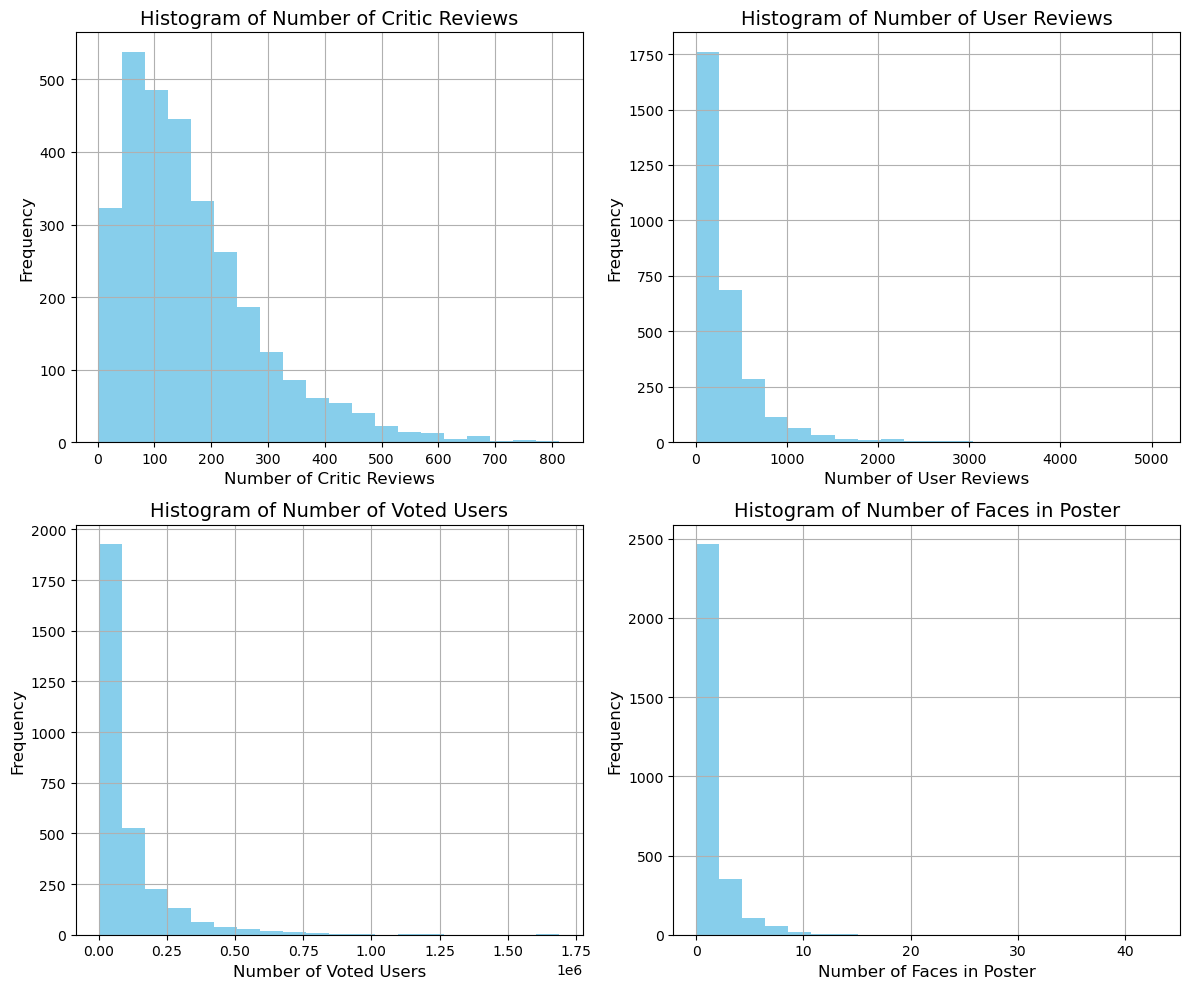

In [15]:
# Creating a 2x2 subplot layout
plt.figure(figsize=(12, 10))

# Plotting histogram for num_critic_for_reviews
plt.subplot(2, 2, 1)
plt.hist(train_dataset['num_critic_for_reviews'], bins=20, color='skyblue')
plt.xlabel('Number of Critic Reviews', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Number of Critic Reviews', fontsize=14)
plt.grid(True)

# Plotting histogram for num_user_for_reviews
plt.subplot(2, 2, 2)
plt.hist(train_dataset['num_user_for_reviews'], bins=20, color='skyblue')
plt.xlabel('Number of User Reviews', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Number of User Reviews', fontsize=14)
plt.grid(True)

# Plotting histogram for num_voted_users
plt.subplot(2, 2, 3)
plt.hist(train_dataset['num_voted_users'], bins=20, color='skyblue')
plt.xlabel('Number of Voted Users', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Number of Voted Users', fontsize=14)
plt.grid(True)

# Plotting histogram for facenumber_in_poster
plt.subplot(2, 2, 4)
plt.hist(train_dataset['facenumber_in_poster'], bins=20, color='skyblue')
plt.xlabel('Number of Faces in Poster', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Number of Faces in Poster', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


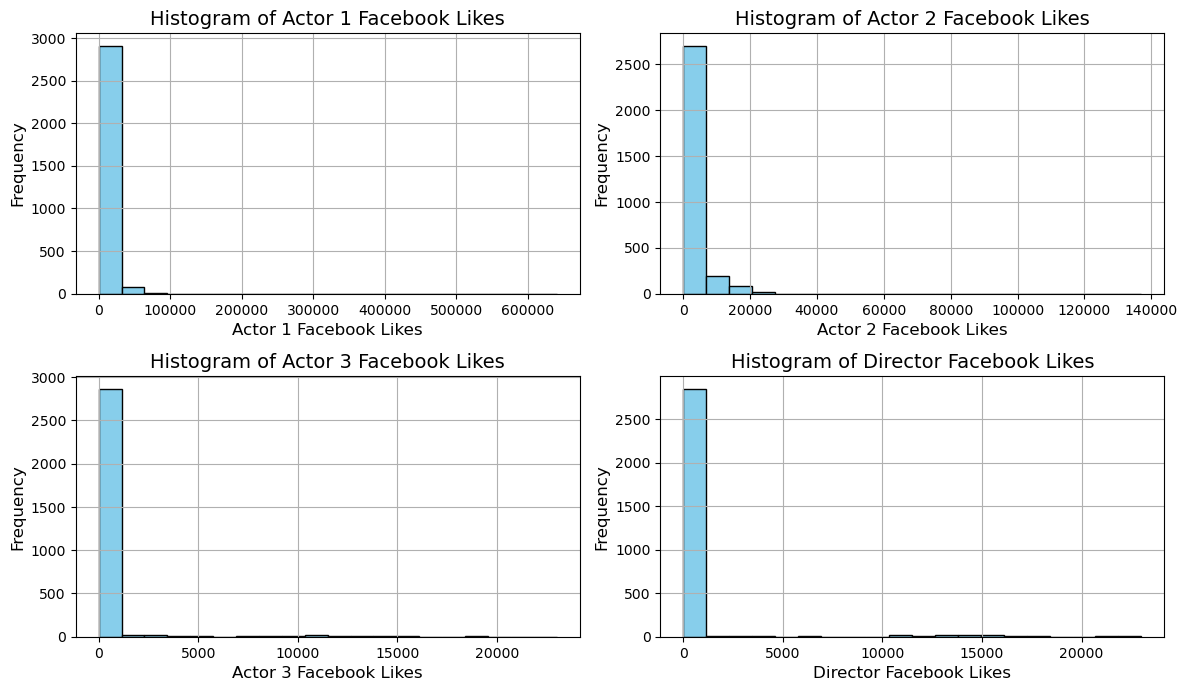

In [16]:
# Plotting histogram for actor_1_facebook_likes
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.hist(train_dataset['actor_1_facebook_likes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Actor 1 Facebook Likes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Actor 1 Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting histogram for actor_2_facebook_likes
plt.subplot(3, 2, 2)
plt.hist(train_dataset['actor_2_facebook_likes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Actor 2 Facebook Likes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Actor 2 Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting histogram for actor_3_facebook_likes
plt.subplot(3, 2, 3)
plt.hist(train_dataset['actor_3_facebook_likes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Actor 3 Facebook Likes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Actor 3 Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting histogram for director_facebook_likes
plt.subplot(3, 2, 4)
plt.hist(train_dataset['director_facebook_likes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Director Facebook Likes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Director Facebook Likes', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


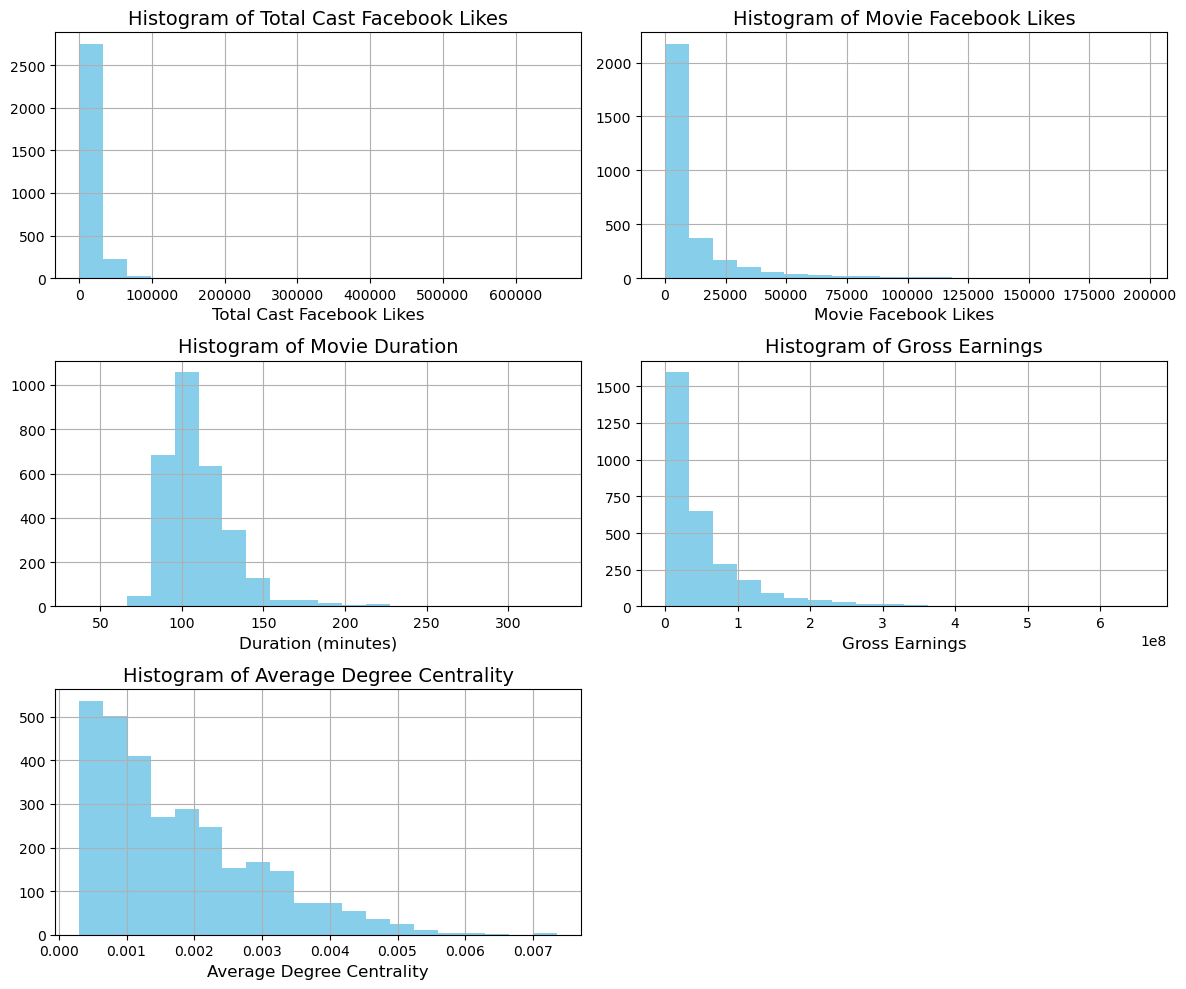

In [17]:
# Plotting histogram for cast_total_facebook_likes
plt.figure(figsize=(12, 10))

plt.subplot(3, 2, 1)
plt.hist(train_dataset['cast_total_facebook_likes'], bins=20, color='skyblue')
plt.xlabel('Total Cast Facebook Likes', fontsize=12)
plt.title('Histogram of Total Cast Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting histogram for movie_facebook_likes
plt.subplot(3, 2, 2)
plt.hist(train_dataset['movie_facebook_likes'], bins=20, color='skyblue')
plt.xlabel('Movie Facebook Likes', fontsize=12)
plt.title('Histogram of Movie Facebook Likes', fontsize=14)
plt.grid(True)

# Plotting histogram for duration
plt.subplot(3, 2, 3)
plt.hist(train_dataset['duration'], bins=20, color='skyblue')
plt.xlabel('Duration (minutes)', fontsize=12)
plt.title('Histogram of Movie Duration', fontsize=14)
plt.grid(True)

# Plotting histogram for gross earnings
plt.subplot(3, 2, 4)
plt.hist(train_dataset['gross'], bins=20, color='skyblue')
plt.xlabel('Gross Earnings', fontsize=12)
plt.title('Histogram of Gross Earnings', fontsize=14)
plt.grid(True)

# Plotting histogram for average_degree_centrality
plt.subplot(3, 2, 5)
plt.hist(train_dataset['average_degree_centrality'], bins=20, color='skyblue')
plt.xlabel('Average Degree Centrality', fontsize=12)
plt.title('Histogram of Average Degree Centrality', fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()


Upon closer inspection with the histograms for the numerical features, we are able to gain a clearer understanding of their distributions. While outliers may initially appear concerning from the boxplots, the distribution of the numerical variables as seen from the histogram appears to be within an acceptable range, and does not necessarily indicate anomalous oberservations, hence does not require immediate action.

#### 2.2.3 Correlation Analysis

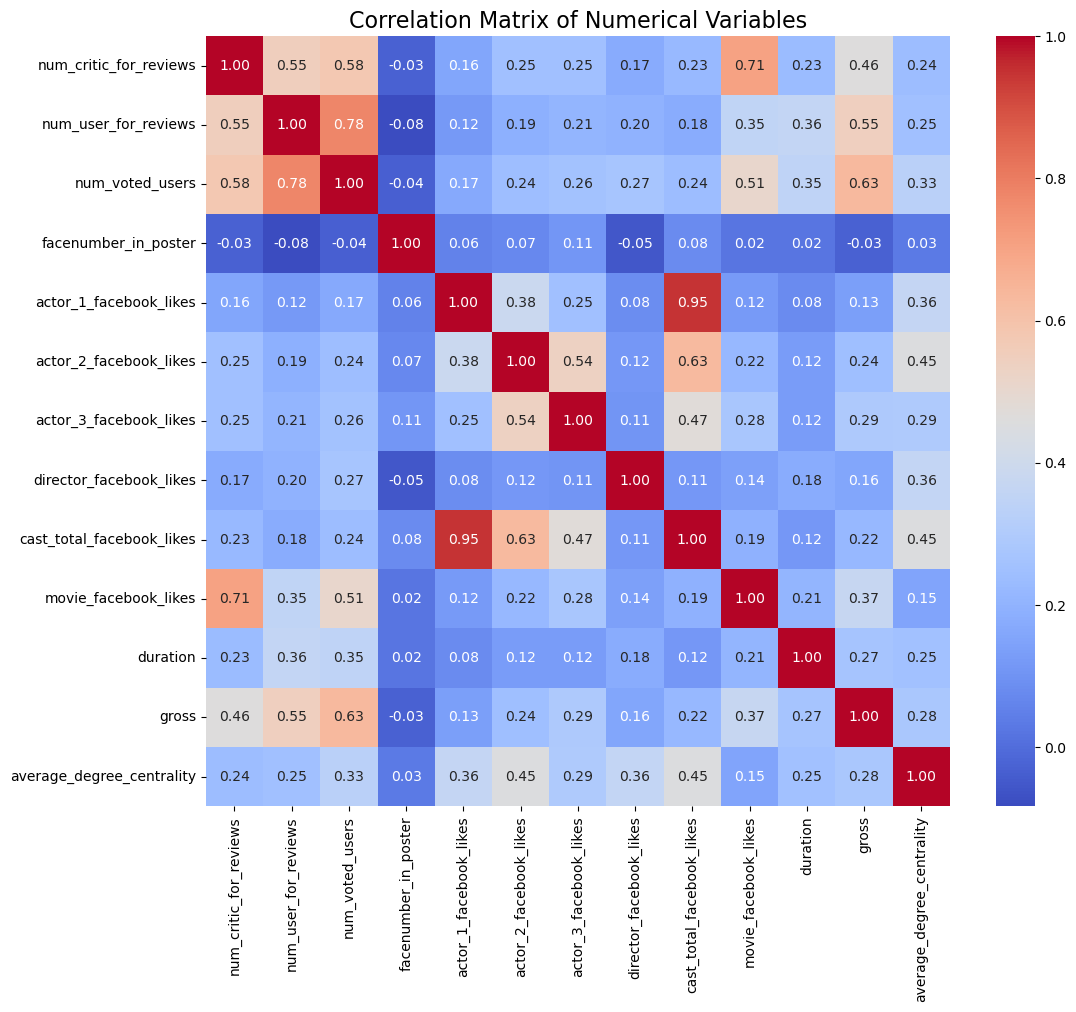

In [18]:
# Selecting numerical columns
numerical_columns = ['num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                     'facenumber_in_poster', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                     'actor_3_facebook_likes', 'director_facebook_likes', 'cast_total_facebook_likes',
                     'movie_facebook_likes', 'duration', 'gross', 'average_degree_centrality']

# Calculating correlation matrix
correlation_matrix = train_dataset[numerical_columns].corr()

# Plotting correlation matrix as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


From the correlation matrix for numerical variables, we will be looking out for variables which are highly correlated. High correlation between feature variables could lead to multicollinearity, which might affect the performance and interpretability of certain machine learning models. This is because when 2 variables are highly correlated, the model may end up overemphasising the importance of these 2 features, leading to unrelaible estimates on its effect on the target variable. Multicollinearity can also lead to challenges in interpreting the individual effects of features on the target variable. (Ashraf, 2023)

From the matrix, we can see that actor_1_facebook_likes and cast_total_facebook_likes are highly correlated (r = 0.95). To solve this, we will remove one of the variables, cast_total_facebook_likes.

In [19]:
# Remove the 'cast_total_facebook_likes' variable from the train dataset
train_dataset.drop(columns=['cast_total_facebook_likes'], inplace=True)
train_dataset.head()

# Remove the 'cast_total_facebook_likes' variable from the test dataset
test_dataset.drop(columns=['cast_total_facebook_likes'], inplace=True)

## 3. Data Pre-Processing

In the data pre-processing section, we will clean and transform the data into a understable and usable format and input for our machine learning models.

In [20]:
train_dataset.head()

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,title_year,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality,imdb_score_binned
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,Adventure|Animation|Drama|Family|Musical,...,656,English,USA,G,1994,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576,4
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,Horror,...,662,English,Canada,R,2005,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675,2
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Drama,...,118,English,USA,R,2013,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002,2
3,4,John Carpenter,297,109,0,145,Richard Masur,957,13782838,Horror|Mystery|Sci-Fi,...,911,English,USA,R,1982,163,23000,[-5.32674184e-03 3.60742491e-03 7.91795843e-...,0.001726,4
4,5,Peter Jackson,297,171,0,857,Orlando Bloom,16000,313837577,Action|Adventure|Drama|Fantasy,...,5060,English,New Zealand,PG-13,2001,5000,21000,[-4.2586620e-03 3.6257182e-03 -1.5326265e-03 ...,0.001876,4


### 3.1 Removing NA Columns

We will first look through train_dataset to see if there are any missing data and the type of missing data to determine the next further course of action if necessary.

In [21]:
# Check for missing values in the train_dataset
missing_values = train_dataset.isna().sum()

# Calculate the percentage of missing values for each column
missing_percentage = (train_dataset.isna().mean() * 100).round(2)

# Display columns with missing values along with the percentage
missing_values_with_percentage = missing_values[missing_values > 0].to_frame()
missing_values_with_percentage.columns = ['Missing Percentage']

if missing_values_with_percentage.empty:
    print("No missing values in any column.")
else:
    print("Columns with missing values and their respective percentages:")
    print(missing_values_with_percentage)



No missing values in any column.


We can see that there are no missing values in the train_dataset, hence no data imputation or removal will be performed regarding NA columns.

### 3.2 Aggregation of Columns

In [22]:
# Create a DataFrame with the number of unique categories for each variable
unique_categories_data = {
    "Variable": ["Director Name", "Actor 1 Name", "Actor 2 Name", "Actor 3 Name", "Genres", 
                 "Movie Title", "Language", "Country", "Content Rating", "Title Year"],
    "Number of Unique Categories": [
        train_dataset['director_name'].nunique(),
        train_dataset['actor_1_name'].nunique(),
        train_dataset['actor_2_name'].nunique(),
        train_dataset['actor_3_name'].nunique(),
        train_dataset['genres'].nunique(),
        train_dataset['movie_title'].nunique(),
        train_dataset['language'].nunique(),
        train_dataset['country'].nunique(),
        train_dataset['content_rating'].nunique(),
        train_dataset['title_year'].nunique()
    ]
}

# Create a DataFrame
unique_categories_df = pd.DataFrame(unique_categories_data)

# Print the DataFrame
print(unique_categories_df)


         Variable  Number of Unique Categories
0   Director Name                         1460
1    Actor 1 Name                         1265
2    Actor 2 Name                         1903
3    Actor 3 Name                         2198
4          Genres                          675
5     Movie Title                         2942
6        Language                           33
7         Country                           42
8  Content Rating                           12
9      Title Year                           72


From the exploratory data analysis above, we also found out that some categorical variable had a large number of unique categories, which might lead to the curse of dimensionality and which can lead to computational challenges for the machine learning models. Therefore in this section, we will seek to aggregate the necessary columns.

#### 3.2.1 'title_year' column

We will first thandle the 'Title Year' column which has 72 unique years, into bins of 10 years.

In [23]:
# Define the bin edges
bin_edges = list(range(1920, 2030, 10))  # Adjust the range as needed

# Define the bin labels
bin_labels = [f"{start}-{start+9}" for start in bin_edges[:-1]]

# Apply binning to train_dataset
train_dataset['Title_Year_Binned'] = pd.cut(train_dataset['title_year'], bins=bin_edges, labels=bin_labels, right=False)

# Apply binning to test_dataset
test_dataset['Title_Year_Binned'] = pd.cut(test_dataset['title_year'], bins=bin_edges, labels=bin_labels, right=False)

# Drop the original 'Title_Year' column
train_dataset.drop(columns=['title_year'], inplace=True)
test_dataset.drop(columns=['title_year'], inplace=True)
train_dataset.head()


,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality,imdb_score_binned,Title_Year_Binned
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,Adventure|Animation|Drama|Family|Musical,...,656,English,USA,G,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576,4,1990-1999
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,Horror,...,662,English,Canada,R,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675,2,2000-2009
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Drama,...,118,English,USA,R,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002,2,2010-2019
3,4,John Carpenter,297,109,0,145,Richard Masur,957,13782838,Horror|Mystery|Sci-Fi,...,911,English,USA,R,163,23000,[-5.32674184e-03 3.60742491e-03 7.91795843e-...,0.001726,4,1980-1989
4,5,Peter Jackson,297,171,0,857,Orlando Bloom,16000,313837577,Action|Adventure|Drama|Fantasy,...,5060,English,New Zealand,PG-13,5000,21000,[-4.2586620e-03 3.6257182e-03 -1.5326265e-03 ...,0.001876,4,2000-2009


In [24]:
# Get the count for each category 
year_counts = train_dataset['Title_Year_Binned'].value_counts()
print("Counts for each category in Title_Year_Binned:")
print(year_counts)

# Check for NaN values 
nan_count = train_dataset['Title_Year_Binned'].isnull().sum()
print("Number of NaN values in Title_Year_Binned:", nan_count)

num_unique_cat = train_dataset['Title_Year_Binned'].nunique()
print("Number of unique categories for Title_Year_Binned", num_unique_cat)

Counts for each category in Title_Year_Binned:
2000-2009    1399
2010-2019     769
1990-1999     573
1980-1989     180
1970-1979      43
1960-1969      21
1950-1959       8
1930-1939       5
1940-1949       5
1920-1929       1
Name: Title_Year_Binned, dtype: int64
Number of NaN values in Title_Year_Binned: 0
Number of unique categories for Title_Year_Binned 10


#### 3.2.2 'country' column

Next, we will aggregate the 42 unique countries into the 7 continents. The broad geographical information provided by continent is still likely to capture the specific country data, therefore information would not be lost and dimensionality can be reduced at the same time. Values that are not country related will be labelled as 'Others', and will be removed later.

In [25]:
# Define a dictionary mapping countries to continents
country_to_continent = {
    'USA': 'North America',
    'UK': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Canada': 'North America',
    'Australia': 'Australia',
    'Spain': 'Europe',
    'Japan': 'Asia',
    'New Zealand': 'Australia',
    'China': 'Asia',
    'Hong Kong': 'Asia',
    'Italy': 'Europe',
    'South Korea': 'Asia',
    'Ireland': 'Europe',
    'Mexico': 'North America',
    'Denmark': 'Europe',
    'Brazil': 'South America',
    'Thailand': 'Asia',
    'South Africa': 'Africa',
    'Argentina': 'South America',
    'Iran': 'Asia',
    'Netherlands': 'Europe',
    'India': 'Asia',
    'Norway': 'Europe',
    'Taiwan': 'Asia',
    'Czech Republic': 'Europe',
    'Russia': 'Europe',
    'Romania': 'Europe',
    'Hungary': 'Europe',
    'Colombia': 'South America',
    'Israel': 'Asia',
    'West Germany': 'Europe',
    'Afghanistan': 'Asia',
    'Aruba': 'North America',
    'Chile': 'South America',
    'Finland': 'Europe',
    'Iceland': 'Europe',
    'Poland': 'Europe',
    'Belgium': 'Europe',
    'New Line': 'Others',
    'Indonesia': 'Asia',
    'Official site': 'Others'
}

# Apply the mapping to both train_dataset and test_dataset
train_dataset['country'] = train_dataset['country'].map(country_to_continent)
test_dataset['country'] = test_dataset['country'].map(country_to_continent)


# Rename the 'country' column to 'continent' in both train_dataset and test_dataset
train_dataset.rename(columns={'country': 'continent'}, inplace=True)
test_dataset.rename(columns={'country': 'continent'}, inplace=True)


In [26]:
# Get the count for each category 
continent_counts = train_dataset['continent'].value_counts()
print("Counts for each category in continent:")
print(continent_counts)

# Check for NaN values 
nan_count = train_dataset['continent'].isnull().sum()
print("Number of NaN values in continent:", nan_count)

num_unique_cat = train_dataset['continent'].nunique()
print("Number of unique categories for continent", num_unique_cat)

Counts for each category in continent:
North America    2435
Europe            462
Asia               51
Australia          42
South America       9
Africa              3
Others              2
Name: continent, dtype: int64
Number of NaN values in continent: 0
Number of unique categories for continent 7


### 3.3 Text Processing

In [27]:
train_dataset.head()

,id,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,continent,content_rating,actor_2_facebook_likes,movie_facebook_likes,title_embedding,average_degree_centrality,imdb_score_binned,Title_Year_Binned
0,1,Roger Allers,186,73,28,847,Nathan Lane,2000,422783777,Adventure|Animation|Drama|Family|Musical,...,656,English,North America,G,886,17000,[-4.1984697e-03 4.2941985e-03 -1.1961063e-03 ...,0.001576,4,1990-1999
1,2,George A. Romero,252,97,0,233,Shawn Roberts,654,20433940,Horror,...,662,English,North America,R,529,0,[-4.7586653e-03 2.6511205e-03 -3.7954253e-04 ...,0.000675,2,2000-2009
2,3,David Gordon Green,232,117,234,221,Tye Sheridan,12000,371897,Drama,...,118,English,North America,R,1000,11000,[ 2.78131524e-03 -3.15494463e-03 -6.38332494e-...,0.003002,2,2010-2019
3,4,John Carpenter,297,109,0,145,Richard Masur,957,13782838,Horror|Mystery|Sci-Fi,...,911,English,North America,R,163,23000,[-5.32674184e-03 3.60742491e-03 7.91795843e-...,0.001726,4,1980-1989
4,5,Peter Jackson,297,171,0,857,Orlando Bloom,16000,313837577,Action|Adventure|Drama|Fantasy,...,5060,English,Australia,PG-13,5000,21000,[-4.2586620e-03 3.6257182e-03 -1.5326265e-03 ...,0.001876,4,2000-2009


#### 3.3.1 Vectorising 'actor_3_name' Column using CountVectorizer

Next, we will move on to text processing. Before we combine the vectorised fields for director_name, actor_1_name, actor_2_name, plot_keywords and genres, we need to look into the last textual column that has not been vectorised - actor_3_name. For actor_3_name, we will use CountVectorizer from Scikit-Learn, similar to actor_1_name and actor_2_name.

In [28]:
# Initialize CountVectorizer
count_vectorizer_actor3 = CountVectorizer()

# Fit and transform the training data
train_countvec_features_actor_3_name = count_vectorizer_actor3.fit_transform(train_dataset['actor_3_name'])

# Transform the test data
test_countvec_features_actor_3_name = count_vectorizer_actor3.transform(test_dataset['actor_3_name'])

# Convert the scipy sparse matrix to a numpy array
train_countvec_features_actor_3_name = train_countvec_features_actor_3_name.toarray()
test_countvec_features_actor_3_name = test_countvec_features_actor_3_name.toarray()

# Check the shape of train_countvec_features_actor_3_name
train_countvec_features_actor_3_name.shape

(3004, 2911)

#### 3.3.2 Replacing Textual Columns with Vectorised Columns

Now, we will replace the following columns with the respective vectorised columns : actor_1_name, actor_2_name, actor_3_name, director_name, genres, movie_title, title_embedding, plot_keywords for both the train_dataset and test_dataset.

In [29]:
# Convert numpy arrays to DataFrames
train_countvec_features_actor_1_name_df = pd.DataFrame(train_countvec_features_actor_1_name, columns=[f'actor_1_name_{i}' for i in range(train_countvec_features_actor_1_name.shape[1])])
train_countvec_features_actor_2_name_df = pd.DataFrame(train_countvec_features_actor_2_name, columns=[f'actor_2_name_{i}' for i in range(train_countvec_features_actor_2_name.shape[1])])
train_countvec_features_actor_3_name_df = pd.DataFrame(train_countvec_features_actor_3_name, columns=[f'actor_3_name_{i}' for i in range(train_countvec_features_actor_3_name.shape[1])])
train_countvec_features_director_name_df = pd.DataFrame(train_countvec_features_director_name, columns=[f'director_name_{i}' for i in range(train_countvec_features_director_name.shape[1])])
train_doc2vec_features_genre_df = pd.DataFrame(train_doc2vec_features_genre, columns=[f'genre_{i}' for i in range(train_doc2vec_features_genre.shape[1])])
train_fasttext_title_embeddings_df = pd.DataFrame(train_fasttext_title_embeddings, columns=[f'title_embedding_{i}' for i in range(train_fasttext_title_embeddings.shape[1])])
train_doc2vec_features_plot_keywords_df = pd.DataFrame(train_doc2vec_features_plot_keywords, columns=[f'plot_keyword_{i}' for i in range(train_doc2vec_features_plot_keywords.shape[1])])

test_countvec_features_actor_1_name_df = pd.DataFrame(test_countvec_features_actor_1_name, columns=[f'actor_1_name_{i}' for i in range(test_countvec_features_actor_1_name.shape[1])])
test_countvec_features_actor_2_name_df = pd.DataFrame(test_countvec_features_actor_2_name, columns=[f'actor_2_name_{i}' for i in range(test_countvec_features_actor_2_name.shape[1])])
test_countvec_features_actor_3_name_df = pd.DataFrame(test_countvec_features_actor_3_name, columns=[f'actor_3_name_{i}' for i in range(test_countvec_features_actor_3_name.shape[1])])
test_countvec_features_director_name_df = pd.DataFrame(test_countvec_features_director_name, columns=[f'director_name_{i}' for i in range(test_countvec_features_director_name.shape[1])])
test_doc2vec_features_genre_df = pd.DataFrame(test_doc2vec_features_genre, columns=[f'genre_{i}' for i in range(test_doc2vec_features_genre.shape[1])])
test_fasttext_title_embeddings_df = pd.DataFrame(test_fasttext_title_embeddings, columns=[f'title_embedding_{i}' for i in range(test_fasttext_title_embeddings.shape[1])])
test_doc2vec_features_plot_keywords_df = pd.DataFrame(test_doc2vec_features_plot_keywords, columns=[f'plot_keyword_{i}' for i in range(test_doc2vec_features_plot_keywords.shape[1])])

# Drop the old columns from both train and test sets
# Remember to drop both movie_title and title_embedding
train_dataset.drop(columns=['actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name', 'genres', 'movie_title', 'plot_keywords', 'title_embedding'], inplace=True)
test_dataset.drop(columns=['actor_1_name', 'actor_2_name', 'actor_3_name', 'director_name', 'genres', 'movie_title', 'plot_keywords', 'title_embedding'], inplace=True)

# Concatenate the new vectorized columns to the train and test sets
train_dataset = pd.concat([train_dataset, train_countvec_features_actor_1_name_df, train_countvec_features_actor_2_name_df, train_countvec_features_actor_3_name_df, train_countvec_features_director_name_df, train_doc2vec_features_genre_df, train_fasttext_title_embeddings_df, train_doc2vec_features_plot_keywords_df], axis=1)
test_dataset = pd.concat([test_dataset, test_countvec_features_actor_1_name_df, test_countvec_features_actor_2_name_df, test_countvec_features_actor_3_name_df, test_countvec_features_director_name_df, test_doc2vec_features_genre_df, test_fasttext_title_embeddings_df, test_doc2vec_features_plot_keywords_df], axis=1)

In [30]:
train_dataset.head()

,id,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,facenumber_in_poster,num_user_for_reviews,...,plot_keyword_90,plot_keyword_91,plot_keyword_92,plot_keyword_93,plot_keyword_94,plot_keyword_95,plot_keyword_96,plot_keyword_97,plot_keyword_98,plot_keyword_99
0,1,186,73,28,847,2000,422783777,644348,0,656,...,-0.000493,-0.003545,0.004082,0.003446,-0.000907,0.001471,-0.001883,0.002502,-0.002413,-0.000206
1,2,252,97,0,233,654,20433940,78883,8,662,...,0.003673,0.001285,0.002591,-0.000728,0.003440,-0.003017,0.001101,0.004059,0.002112,-0.002319
2,3,232,117,234,221,12000,371897,36494,2,118,...,-0.001566,-0.002651,0.004508,-0.001642,-0.004585,-0.003740,0.003329,0.003480,-0.004858,0.004275
3,4,297,109,0,145,957,13782838,258078,0,911,...,0.003669,0.002197,-0.003719,0.002790,0.004540,-0.000552,-0.004196,0.003911,-0.001663,-0.003593
4,5,297,171,0,857,16000,313837577,1238746,2,5060,...,0.004995,0.003198,0.002475,-0.003280,-0.000682,0.002077,0.003112,-0.004794,-0.001134,-0.004481


### 3.4 Removing Rows With Irrelavant or Ambiguous Information

For this section, we will be removing rows with irrelavant or ambiguous information to streamline the dataset. This ensures that the dataset is focused on meaningful variables that contribute to the analysis or prediction task.

#### 3.4.1 'continent' column

In [31]:
# Print value counts for 'continent'
print("Value counts for 'continent':")
print(train_dataset['continent'].value_counts())
print()

Value counts for 'continent':
North America    2435
Europe            462
Asia               51
Australia          42
South America       9
Africa              3
Others              2
Name: continent, dtype: int64



During the aggregation of the country column into continents above, data which irrelavant to country were classified as 'Others'. From above, we can see that there are 2 rows are classified as 'Others' in train_dataset, and will be removed since these 2 data points are not likely to contribute to any meaningful feature for the machine learning model.

In [32]:
# Remove rows with continent labeled as 'Others' from train_dataset
train_dataset = train_dataset[train_dataset['continent'] != 'Others']

# Remove rows with continent labeled as 'Others' from test_dataset
test_dataset = test_dataset[test_dataset['continent'] != 'Others']


In [33]:
# Print value counts for 'continent'
print("Value counts for 'continent':")
print(train_dataset['continent'].value_counts())
print()

Value counts for 'continent':
North America    2435
Europe            462
Asia               51
Australia          42
South America       9
Africa              3
Name: continent, dtype: int64



#### 3.4.2 'id' column
We will be removing the 'id' column from the train_dataset and test_dataset because it serves as an identifier and is likely to not provide any valuable information for the prediction of 'imdb_score_binned'. Including id as a feature would likely to introduce noise to the model, without any added predictive performance.

In [34]:
# Remove the 'id' variable from the train dataset
train_dataset.drop(columns=['id'], inplace=True)
train_dataset.head()

# Remove the 'id' variable from the test dataset
# Save the 'id' variable before dropping
test_id = test_dataset['id'].copy() # for kaggle
test_dataset.drop(columns=['id'], inplace=True)

### 3.5 Train-Test Split

Next, we will be further splitting the train data, dividing it with a 70-30 ratio, naming it train_dataset_A and test_dataset_A respectively. As the test set does not have labels, we will create a validation set from the training data to access the model performance. This will allow us to estimate how well the model might generalize to unseen data as we check the model's performance against known labels before finalizing its deployment.

The train-test split here is also done before the text preprocessing, encoding (one hot encoding and target encoding) and feature scaling to prevent data leakage. Data leakage happens when text preprocessing or encoding techniques are applied to the entire dataset, because the model could be learning test set information that should not be accessed during model training. Applying train-test split before feature scaling also prevents the data distribution in the test dataset from influencing the process of scaling. By conducting train-test split before all these steps, we can ensure that the model will only be trained on training data and evaluated on test set unseen data. (Brownlee, 2020)

In [35]:
# Define the target variable
target_variable = train_dataset['imdb_score_binned']

# Splitting the train data into train and validation sets with a 70-30 ratio
train_dataset_A, test_dataset_A, train_dataset_target_A, test_dataset_target_A = train_test_split(train_dataset, target_variable, test_size=0.3, random_state=42)

# Check the shapes of the newly split datasets
print("Shape of train_dataset_A:", train_dataset_A.shape)
print("Shape of train_dataset_target_A:", train_dataset_target_A.shape)


Shape of train_dataset_A: (2101, 10323)
Shape of train_dataset_target_A: (2101,)


### 3.6 Encoding Categorical Variables

Next, we will be encoding the remaining categorical variables to make it suitable to for input into machine learning models. We will be primarily using 2 main forms of encoding - one-hot encoding and target encoding. One hot encoding will be applied to features with fewer distinct categories (continent, content_rating, title_year) while target encoding will be applied to features with more distinct categories (language). 

This is because one-hot encoding creates binary columns for each respective category, and hence is not likely to work well for features having many distinct categories because it will lead to an increase in dimensionality. This is undesirable especially if the dataset is large as it is likely to reduce computational performance of the models. (Jain, 2024)

Target encoding on the other hand, replaces the categorical variables with the mean of the target variable (imdb_score_binned) for each category. This method is suitable for predictors with more distinct categories because all the information is condensed into a column, hence allowing the models to capture meaningful relatonship between the predictor and target variable and reducing dimensionality at the same time.

#### 3.6.1 One-Hot Encoding

In [36]:
# One-hot encoding for features with fewer distinct categories
one_hot_cols = ['continent', 'content_rating', 'Title_Year_Binned']

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Fit and transform the training data
train_A_one_hot_encoded = one_hot_encoder.fit_transform(train_dataset_A[one_hot_cols])
test_A_one_hot_encoded = one_hot_encoder.transform(test_dataset_A[one_hot_cols])
test_one_hot_encoded = one_hot_encoder.transform(test_dataset[one_hot_cols])

# Get the feature names after one-hot encoding
one_hot_feature_names = one_hot_encoder.get_feature_names_out(input_features=one_hot_cols)

train_A_one_hot_encoded_df = pd.DataFrame(train_A_one_hot_encoded.toarray(), columns=one_hot_feature_names, index=train_dataset_A.index)
test_A_one_hot_encoded_df = pd.DataFrame(test_A_one_hot_encoded.toarray(), columns=one_hot_feature_names, index=test_dataset_A.index)
test_one_hot_encoded_df = pd.DataFrame(test_one_hot_encoded.toarray(), columns=one_hot_feature_names, index=test_dataset.index)


# Drop the original columns from train and test datasets
train_dataset_A = train_dataset_A.drop(columns=one_hot_cols)
test_dataset_A = test_dataset_A.drop(columns=one_hot_cols)
test_dataset = test_dataset.drop(columns=one_hot_cols)


# Concatenate the one-hot encoded columns to the train and test datasets
train_dataset_A = pd.concat([train_dataset_A, train_A_one_hot_encoded_df], axis=1)
test_dataset_A = pd.concat([test_dataset_A, test_A_one_hot_encoded_df], axis=1)
test_dataset = pd.concat([test_dataset, test_one_hot_encoded_df], axis=1)

print(train_dataset_A.shape)
print(test_dataset_A.shape)
print(test_dataset.shape)

(2101, 10347)
(901, 10347)
(752, 10346)


#### 3.6.2 Target Encoding

In [37]:
# Target encoding for features with more distinct categories
target_enc_col = 'language'

# Initialize TargetEncoder
target_encoder = TargetEncoder()

# Fit and transform the training data
train_dataset_A[target_enc_col] = target_encoder.fit_transform(train_dataset_A[target_enc_col], train_dataset_A['imdb_score_binned'])
test_dataset_A[target_enc_col] = target_encoder.transform(test_dataset_A[target_enc_col])
test_dataset[target_enc_col] = target_encoder.transform(test_dataset[target_enc_col])

# Remove 'imdb_score_binned' from train_dataset_A 
train_dataset_A_target = train_dataset_A.pop('imdb_score_binned')
# Remove 'imdb_score_binned' from test_dataset_A 
test_dataset_A_target = test_dataset_A.pop('imdb_score_binned')

### 3.7 Feature Scaling (Numerical Data)

Next, feature scaling for numerical data will be applied. Commonly, features are not on the same scale, however machine learning models are often euclidean distance-based. (Shivanipickl, 2023) To prevent features with larger units dominating features with smaller units during distance calculation, we will be using Min-Max scaling, MinMaxScaler(), for scaling the numerical features in our dataset. Numerical features will be scaled ot a range of 0-1 after the the data is preprocessed through Min-Max scaling.

In [38]:
# Features to be scaled
numerical_features = [
    'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
    'facenumber_in_poster', 'duration', 'actor_1_facebook_likes',
    'actor_2_facebook_likes', 'actor_3_facebook_likes',
    'director_facebook_likes',
    'movie_facebook_likes', 'gross', 'average_degree_centrality'
]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
train_dataset_A[numerical_features] = scaler.fit_transform(train_dataset_A[numerical_features])

# Transform the test data using the scaler fitted on the training data
test_dataset_A[numerical_features] = scaler.transform(test_dataset_A[numerical_features])
test_dataset[numerical_features] = scaler.transform(test_dataset[numerical_features])


## 4. Feature Selection

In this section, we will aim to enhance the effectiveness of the machine learning models run later by prioritising the most relevant features from the dataset, while dropping the less informative ones. This process is crucial to improve the model performance of the machine learning models as well as reduce overfitting.

### 4.1. Undersampling & Oversampling

The first feature selection method I will be using will be undersampling and oversampling techniques, to address the class imbalance of imdb_score_binned, as mentioned in the exploratory data analysis, where imdb_score_binned = 2 and imdb_score_binned = 3 was found to take up more than 85% of the total number of sample. A large class balance may pose a challenge to machine learning models, where the majority classes are overrepresented while the minority classes are underrepresented, and may cuase models to struggle to effectively learn patterns from minority classes and lead to biased predictions and reduced model performance. (Peebles, 2022)

Therefore, undersampling and oversampling techniques will be used, where undersampling would reduce the size of the classes which are overrepresented, and oversampling will increase the size of the classes that are underrepresented, overall balancing out the distribution. This prevents overrepresentation or underrepresentation of the classes during model training.

However, synthetic samples will only be generated for the train_dataset, not test_dataset, because synthetic samples do not belong to the target distribution hence will be used on the test_dataset.

In [39]:
# Define the pipeline for combining SMOTE and undersampling
pipeline = Pipeline([
    ('oversample', SMOTE(random_state=42)),
    ('undersample', RandomUnderSampler(random_state=42))
])

# Apply the pipeline to the train_dataset and train_dataset_target
train_dataset_A_resampled, train_dataset_A_target_resampled = pipeline.fit_resample(train_dataset_A, train_dataset_A_target)

# Print the class distribution after resampling
print("Class distribution after resampling:")
print(np.bincount(train_dataset_A_target_resampled))


Class distribution after resampling:
[1299 1299 1299 1299 1299]


## 5. Model Selection

For this section, we will be running 4 machine learning models, and thereafter test and evaluate the performance of the models. The best model will be selected, and is crucial as we want a predictive model that is able to generalise to unseen data well. We will also be running hyperparamter tuning in the next section to select the optimal hyperparameters

The datasets we will be using are:
1) Original Trainset (train_dataset)
2) Original Trainset + Oversampling & Undersampling Techniques (train_dataset_resampled)

The models we will be using are:
1) Gaussian Naive Bayes Classifer 
2) K-nearest-neighbours Classifer
3) Random Forest Classifier
4) AdaBoost Classifier

After which, we will be evaluating each respective model with the test set.

### 5.1 Gaussian Naive Bayes Classifer

Gaussian Naive Bayes (GNB) is a supervised machine learning algorithm based on the Bayes Theorem, with an assumption of independence between predictor features. GNB works by calcuating the probability of a data point in each class by assuming that all predictor features are conditionally independent, given the class. Computation is hence tractable and requires a small amount of training data in estimating the classification parameters. (Lavanya, 2022) However, one downside is that feature independence may not be true in all scenarios in the real world, hence leading to less than optimal performance in some areas. As a whole, GNB is easy to implement and a good choice for classifications with features that approximately follow a gaussian distribution.

#### 5.1.1 Original Trainset

In [40]:
# Define Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the model on the original train dataset
gnb.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the original test dataset
original_predictions = gnb.predict(test_dataset_A)

# Calculate accuracy
accuracy_gnb_org = accuracy_score(test_dataset_A_target, original_predictions)

# Calculate precision
precision_gnb_org = precision_score(test_dataset_A_target, original_predictions, average='weighted')

# Calculate recall
recall_gnb_org = recall_score(test_dataset_A_target, original_predictions, average='weighted')

# Calculate F1 score
f1_gnb_org = f1_score(test_dataset_A_target, original_predictions, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_gnb_org)
print("Precision:", precision_gnb_org)
print("Recall:", recall_gnb_org)
print("F1 Score:", f1_gnb_org)


Accuracy: 0.5338512763596004
Precision: 0.5071726093994451
Recall: 0.5338512763596004
F1 Score: 0.5192882033926367


#### 5.1.2 Original Trainset + Oversampling & Undersampling Techniques

In [41]:
# Define Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the model on the resampled train dataset
gnb.fit(train_dataset_A_resampled, train_dataset_A_target_resampled)

# Predictions on the original test dataset
original_predictions = gnb.predict(test_dataset_A)

# Calculate accuracy
accuracy_gnb_resampled = accuracy_score(test_dataset_A_target, original_predictions)

# Calculate precision
precision_gnb_resampled = precision_score(test_dataset_A_target, original_predictions, average='weighted')

# Calculate recall
recall_gnb_resampled = recall_score(test_dataset_A_target, original_predictions, average='weighted')

# Calculate F1 score
f1_gnb_resampled = f1_score(test_dataset_A_target, original_predictions, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_gnb_resampled)
print("Precision:", precision_gnb_resampled)
print("Recall:", recall_gnb_resampled)
print("F1 Score:", f1_gnb_resampled)


Accuracy: 0.5338512763596004
Precision: 0.5071726093994451
Recall: 0.5338512763596004
F1 Score: 0.5192882033926367


### 5.2 K-nearest-neighbours Classifer

K-nearest-neighbors (KNN) is a supervised machine learning algorithm based on the principle of identifying the k data points nearest to a given query point in the training set, and using their labels in determining the label of the query point. One advantage of KNN is that it does not make any assumptions about the underlying data distribution. Choosing the optimal value of k is important as it can impact the performance of the classifer significantly. However for large datasets, KNN could be computationally expensive as it will require the calculation of distances between the point of query and all training points. (Srivastava, 2024)

#### 5.2.1 Original Trainset

In [42]:
# Define K Nearest Neighbors classifier
knn = KNeighborsClassifier()

# Train the model on the original train dataset
knn.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the original test dataset
original_predictions_knn = knn.predict(test_dataset_A)

# Calculate accuracy
accuracy_knn_org = accuracy_score(test_dataset_A_target, original_predictions_knn)

# Calculate precision
precision_knn_org = precision_score(test_dataset_A_target, original_predictions_knn, average='weighted')

# Calculate recall
recall_knn_org = recall_score(test_dataset_A_target, original_predictions_knn, average='weighted')

# Calculate F1 score
f1_knn_org = f1_score(test_dataset_A_target, original_predictions_knn, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_knn_org)
print("Precision:", precision_knn_org)
print("Recall:", recall_knn_org)
print("F1 Score:", f1_knn_org)


Accuracy: 0.5915649278579356
Precision: 0.5203763590650374
Recall: 0.5915649278579356
F1 Score: 0.5219565109611302


#### 5.2.2 Original Trainset + Oversampling & Undersampling Techniques

In [43]:
# Define K Nearest Neighbors classifier
knn = KNeighborsClassifier()

# Train the model on the resampled train dataset
knn.fit(train_dataset_A_resampled, train_dataset_A_target_resampled)

# Predictions on the original test dataset
original_predictions_knn = knn.predict(test_dataset_A)

# Calculate accuracy
accuracy_knn_resampled = accuracy_score(test_dataset_A_target, original_predictions_knn)

# Calculate precision
precision_knn_resampled = precision_score(test_dataset_A_target, original_predictions_knn, average='weighted')

# Calculate recall
recall_knn_resampled = recall_score(test_dataset_A_target, original_predictions_knn, average='weighted')

# Calculate F1 score
f1_knn_resampled = f1_score(test_dataset_A_target, original_predictions_knn, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_knn_resampled)
print("Precision:", precision_knn_resampled)
print("Recall:", recall_knn_resampled)
print("F1 Score:", f1_knn_resampled)


Accuracy: 0.23196448390677027
Precision: 0.13089581607851922
Recall: 0.23196448390677027
F1 Score: 0.1581082124435694


### 5.3 Random Forest Classifier

Random Forest is a supervised machine learning algorithm based on the construction of a series of decision trees during training, and outputting the mode of the classes of the individual trees for classification tasks. Majority voting will determine the final prediction for classification tasks. Overfitting is reduced and generalisation performance of the random forest classifier is improved through building each tree from a random subset of training data as well as features. Random forest hence combines the strength of the decision trees, which allow complex interactions and non-linear relationships to be captured, as well as ensemble benefits, which reduced variance and improves robustness of the overall model. (Donges & Whitfield, 2024). 

#### 5.3.1 Original Trainset

In [44]:
# Define Random Forest classifier
rf = RandomForestClassifier()

# Train the model on the original train dataset
rf.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the original test dataset
original_predictions_rf = rf.predict(test_dataset_A)

# Calculate accuracy
accuracy_rf_org = accuracy_score(test_dataset_A_target, original_predictions_rf)

# Calculate precision
precision_rf_org = precision_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Calculate recall
recall_rf_org = recall_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Calculate F1 score
f1_rf_org = f1_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_rf_org)
print("Precision:", precision_rf_org)
print("Recall:", recall_rf_org)
print("F1 Score:", f1_rf_org)


Accuracy: 0.6148723640399556
Precision: 0.6466140879980234
Recall: 0.6148723640399556
F1 Score: 0.5100345691101467


#### 5.3.2 Original Trainset + Oversampling & Undersampling Techniques

In [45]:
# Define Random Forest classifier
rf = RandomForestClassifier()

# Train the model on the original train dataset
rf.fit(train_dataset_A_resampled, train_dataset_A_target_resampled)

# Predictions on the original test dataset
original_predictions_rf = rf.predict(test_dataset_A)

# Calculate accuracy
accuracy_rf_resampled = accuracy_score(test_dataset_A_target, original_predictions_rf)

# Calculate precision
precision_rf_resampled = precision_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Calculate recall
recall_rf_resampled = recall_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Calculate F1 score
f1_rf_resampled = f1_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_rf_resampled)
print("Precision:", precision_rf_resampled)
print("Recall:", recall_rf_resampled)
print("F1 Score:", f1_rf_resampled)


Accuracy: 0.609322974472808
Precision: 0.5715279970229667
Recall: 0.609322974472808
F1 Score: 0.5610794747833607


### 5.4 AdaBoost Classifier

AdaBoost is a supervised ensemble machine learning model which combines a sequence of weak classifiers to create a strong classifier. AdaBoost iteratively trains a sequence of weak classifiers using weighted versions of the train set, and each subsequent classifier will focus on training instances that are misclassified by previous classifiers. A higher weight will be assigned to misclassified instances, thereby building a strong classifier in the process. AdaBoost handles complex datasets particularly well as it focuses on the instances that are most informative and is less prone to overfitting. (Chatterjee, 2022)

#### 5.4.1 Original Trainset

In [46]:
# Define AdaBoost classifier
adaboost = AdaBoostClassifier()

# Train the model on the original train dataset
adaboost.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the original test dataset
original_predictions_adaboost = adaboost.predict(test_dataset_A)

# Calculate accuracy
accuracy_adaboost_org = accuracy_score(test_dataset_A_target, original_predictions_adaboost)

# Calculate precision
precision_adaboost_org = precision_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Calculate recall
recall_adaboost_org = recall_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Calculate F1 score
f1_adaboost_org = f1_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_adaboost_org)
print("Precision:", precision_adaboost_org)
print("Recall:", recall_adaboost_org)
print("F1 Score:", f1_adaboost_org)


Accuracy: 0.6315205327413984
Precision: 0.5599734587068904
Recall: 0.6315205327413984
F1 Score: 0.5793631338354381


#### 5.4.2 Original Trainset + Oversampling & Undersampling Techniques

In [47]:
# Define AdaBoost classifier
adaboost = AdaBoostClassifier()

# Train the model on the original train dataset
adaboost.fit(train_dataset_A_resampled, train_dataset_A_target_resampled)

# Predictions on the original test dataset
original_predictions_adaboost = adaboost.predict(test_dataset_A)

# Calculate accuracy
accuracy_adaboost_resampled = accuracy_score(test_dataset_A_target, original_predictions_adaboost)

# Calculate precision
precision_adaboost_resampled = precision_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Calculate recall
recall_adaboost_resampled = recall_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Calculate F1 score
f1_adaboost_resampled = f1_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_adaboost_resampled)
print("Precision:", precision_adaboost_resampled)
print("Recall:", recall_adaboost_resampled)
print("F1 Score:", f1_adaboost_resampled)


Accuracy: 0.26748057713651496
Precision: 0.5637967534599662
Recall: 0.26748057713651496
F1 Score: 0.2947383548673709


In [48]:
# Define the metrics for each model and dataset
metrics_data = [
    ("Gaussian Naive Bayes", "Original", accuracy_gnb_org, precision_gnb_org, recall_gnb_org, f1_gnb_org),
    ("Gaussian Naive Bayes", "Resampled", accuracy_gnb_resampled, precision_gnb_resampled, recall_gnb_resampled, f1_gnb_resampled),
    ("K-nearest Neighbors", "Original", accuracy_knn_org, precision_knn_org, recall_knn_org, f1_knn_org),
    ("K-nearest Neighbors", "Resampled", accuracy_knn_resampled, precision_knn_resampled, recall_knn_resampled, f1_knn_resampled),
    ("Random Forest", "Original", accuracy_rf_org, precision_rf_org, recall_rf_org, f1_rf_org),
    ("Random Forest", "Resampled", accuracy_rf_resampled, precision_rf_resampled, recall_rf_resampled, f1_rf_resampled),
    ("AdaBoost", "Original", accuracy_adaboost_org, precision_adaboost_org, recall_adaboost_org, f1_adaboost_org),
    ("AdaBoost", "Resampled", accuracy_adaboost_resampled, precision_adaboost_resampled, recall_adaboost_resampled, f1_adaboost_resampled)
]

# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data, columns=["Model", "Dataset", "Accuracy", "Precision", "Recall", "F1 Score"])

# Print the DataFrame
print(metrics_df)


                  Model    Dataset  Accuracy  Precision    Recall  F1 Score
0  Gaussian Naive Bayes   Original  0.533851   0.507173  0.533851  0.519288
1  Gaussian Naive Bayes  Resampled  0.533851   0.507173  0.533851  0.519288
2   K-nearest Neighbors   Original  0.591565   0.520376  0.591565  0.521957
3   K-nearest Neighbors  Resampled  0.231964   0.130896  0.231964  0.158108
4         Random Forest   Original  0.614872   0.646614  0.614872  0.510035
5         Random Forest  Resampled  0.609323   0.571528  0.609323  0.561079
6              AdaBoost   Original  0.631521   0.559973  0.631521  0.579363
7              AdaBoost  Resampled  0.267481   0.563797  0.267481  0.294738


## 6. Hyperparameter Tuning

In this section, we will conduct hyperparameter tuning to optimise the hyperparameters of the machine learning models, in a bid to improve the model performance. Examples of hyperparameters include the number of trees in a random forest and the depth of a decision tree. 

From above, it seems that the models are generally performing better on the original trainset as compared to the original trainset with oversampling and undersampling techniques applied. Therefore, we have decided to conduct hyperparameter tuning on the original trainsets only.

Due to computational constraints, we will be using random search which selects and evaluates random combinations of hyperparamters, instead of grid search which runs through all possible combinations of hyperparameters.

The scoring metric used for evaluating the performance of the hyperparamter tuning chosen is F1-Score.  F1-Score is chosen because it provides a harmonic mean between precision and recall, accurately predicting imbd_score_binned across all classes while at the same time being particularly useful for imbalanced datasets.

K-fold cross-validation is also used (k=5). Cross-validation will repeatedly run by split the dataset into 5 folds, training the model on k-1 folds and evaluating it on the last fold. By averaging the evaluating metrics across the 5 folds, it allows us to obtain a reliable estimate of the machine learning model's performance.

### 6.1 Gaussian Naive Bayes Classifer

In [49]:
# Configure logging
logging.basicConfig(level=logging.INFO)

# Define Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Define the hyperparameter grid
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100),
    'priors': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6], [0.5, 0.5], [0.6, 0.4], [0.7, 0.3], [0.8, 0.2], [0.9, 0.1]],
}

# Define the F1 scorer for scoring
scorer = make_scorer(f1_score, average='weighted')

# Set up random search
random_search = RandomizedSearchCV(gnb, param_distributions=param_grid, n_iter=100, scoring=scorer, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit random search to training data
logging.info("Fitting random search to training data...")
random_search.fit(train_dataset_A, train_dataset_A_target)

# Get the best parameters
best_params = random_search.best_params_
logging.info("Best Parameters: %s", best_params)

# Get the best model
best_gnb = random_search.best_estimator_

# Predictions on the original test dataset
original_predictions = best_gnb.predict(test_dataset_A)

# Calculate accuracy
accuracy_gnb_org = accuracy_score(test_dataset_A_target, original_predictions)

# Calculate precision
precision_gnb_org = precision_score(test_dataset_A_target, original_predictions, average='weighted')

# Calculate recall
recall_gnb_org = recall_score(test_dataset_A_target, original_predictions, average='weighted')

# Calculate F1 score
f1_gnb_org = f1_score(test_dataset_A_target, original_predictions, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_gnb_org)
print("Precision:", precision_gnb_org)
print("Recall:", recall_gnb_org)
print("F1 Score:", f1_gnb_org)


INFO:root:Fitting random search to training data...


Fitting 5 folds for each of 100 candidates, totalling 500 fits


INFO:root:Best Parameters: {'var_smoothing': 1.232846739442066e-07, 'priors': None}


Accuracy: 0.5338512763596004
Precision: 0.5071726093994451
Recall: 0.5338512763596004
F1 Score: 0.5192882033926367


### 6.2 K-nearest-neighbours Classifer

In [50]:
# Configure logging
logging.basicConfig(level=logging.INFO)

# Define K Nearest Neighbors classifier
knn = KNeighborsClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_neighbors': range(1, 10),
    'weights': ['uniform', 'distance'],
}

# Define the F1 scorer for scoring
scorer = make_scorer(f1_score, average='weighted')

# Set up random search
random_search = RandomizedSearchCV(knn, param_distributions=param_grid, n_iter=100, scoring=scorer, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit random search to training data
logging.info("Fitting random search to training data...")
random_search.fit(train_dataset_A, train_dataset_A_target)

# Get the best parameters
best_params = random_search.best_params_
logging.info("Best Parameters: %s", best_params)

# Get the best model
best_knn = random_search.best_estimator_

# Predictions on the original test dataset
original_predictions = best_knn.predict(test_dataset_A)

# Calculate accuracy
accuracy_knn_org = accuracy_score(test_dataset_A_target, original_predictions)

# Calculate precision
precision_knn_org = precision_score(test_dataset_A_target, original_predictions, average='weighted')

# Calculate recall
recall_knn_org = recall_score(test_dataset_A_target, original_predictions, average='weighted')

# Calculate F1 score
f1_knn_org = f1_score(test_dataset_A_target, original_predictions, average='weighted')

# Print the calculated metrics
print("Accuracy:", accuracy_knn_org)
print("Precision:", precision_knn_org)
print("Recall:", recall_knn_org)
print("F1 Score:", f1_knn_org)


INFO:root:Fitting random search to training data...


Fitting 5 folds for each of 18 candidates, totalling 90 fits


INFO:root:Best Parameters: {'weights': 'uniform', 'n_neighbors': 1}


Accuracy: 0.5593784683684795
Precision: 0.5451291350395876
Recall: 0.5593784683684795
F1 Score: 0.5500118593784704


### 6.3 Random Forest Classifier

In [51]:
# Configure logging
logging.basicConfig(level=logging.INFO)

# Define Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 300],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Define the F1 scorer for scoring
scorer_rf = make_scorer(f1_score, average='weighted')

# Set up random search for Random Forest
random_search_rf = RandomizedSearchCV(rf, param_distributions=param_grid_rf, n_iter=100, scoring=scorer_rf, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit random search to training data for Random Forest
logging.info("Fitting random search to training data for Random Forest...")
random_search_rf.fit(train_dataset_A, train_dataset_A_target)

# Get the best parameters for Random Forest
best_params_rf = random_search_rf.best_params_
logging.info("Best Parameters for Random Forest: %s", best_params_rf)

# Get the best model for Random Forest
best_rf = random_search_rf.best_estimator_

# Predictions on the original test dataset for Random Forest
original_predictions_rf = best_rf.predict(test_dataset_A)

# Calculate accuracy for Random Forest
accuracy_rf_org = accuracy_score(test_dataset_A_target, original_predictions_rf)

# Calculate precision for Random Forest
precision_rf_org = precision_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Calculate recall for Random Forest
recall_rf_org = recall_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Calculate F1 score for Random Forest
f1_rf_org = f1_score(test_dataset_A_target, original_predictions_rf, average='weighted')

# Print the calculated metrics for Random Forest
print("Accuracy for Random Forest:", accuracy_rf_org)
print("Precision for Random Forest:", precision_rf_org)
print("Recall for Random Forest:", recall_rf_org)
print("F1 Score for Random Forest:", f1_rf_org)


INFO:root:Fitting random search to training data for Random Forest...


Fitting 5 folds for each of 81 candidates, totalling 405 fits


INFO:root:Best Parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}


Accuracy for Random Forest: 0.6159822419533851
Precision for Random Forest: 0.5551219008563625
Recall for Random Forest: 0.6159822419533851
F1 Score for Random Forest: 0.5032420392624842


### 6.4 AdaBoost Classifier

In [52]:
# Configure logging
logging.basicConfig(level=logging.INFO)

# Define AdaBoost classifier
adaboost = AdaBoostClassifier()

# Define the hyperparameter grid for AdaBoost
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# Define the F1 scorer for scoring
scorer = make_scorer(f1_score, average='weighted')

# Set up random search for AdaBoost
random_search_adaboost = RandomizedSearchCV(adaboost, param_distributions=param_grid_adaboost, n_iter=100, scoring=scorer, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit random search to training data for AdaBoost
logging.info("Fitting random search to training data for AdaBoost...")
random_search_adaboost.fit(train_dataset_A, train_dataset_A_target)

# Get the best parameters for AdaBoost
best_params_adaboost = random_search_adaboost.best_params_
logging.info("Best Parameters for AdaBoost: %s", best_params_adaboost)

# Get the best model for AdaBoost
best_adaboost = random_search_adaboost.best_estimator_

# Predictions on the original test dataset for AdaBoost
original_predictions_adaboost = best_adaboost.predict(test_dataset_A)

# Calculate accuracy for AdaBoost
accuracy_adaboost_org = accuracy_score(test_dataset_A_target, original_predictions_adaboost)

# Calculate precision for AdaBoost
precision_adaboost_org = precision_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Calculate recall for AdaBoost
recall_adaboost_org = recall_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Calculate F1 score for AdaBoost
f1_adaboost_org = f1_score(test_dataset_A_target, original_predictions_adaboost, average='weighted')

# Print the calculated metrics for AdaBoost
print("Accuracy for AdaBoost:", accuracy_adaboost_org)
print("Precision for AdaBoost:", precision_adaboost_org)
print("Recall for AdaBoost:", recall_adaboost_org)
print("F1 Score for AdaBoost:", f1_adaboost_org)


INFO:root:Fitting random search to training data for AdaBoost...


Fitting 5 folds for each of 18 candidates, totalling 90 fits


INFO:root:Best Parameters for AdaBoost: {'n_estimators': 100, 'learning_rate': 1.0, 'algorithm': 'SAMME'}


Accuracy for AdaBoost: 0.6215316315205327
Precision for AdaBoost: 0.5737190532640157
Recall for AdaBoost: 0.6215316315205327
F1 Score for AdaBoost: 0.5825264854073294


In [53]:
# Define the metrics for each model and dataset
metrics_data = [
    ("Gaussian Naive Bayes", "Original", accuracy_gnb_org, precision_gnb_org, recall_gnb_org, f1_gnb_org),
    ("K-nearest Neighbors", "Original", accuracy_knn_org, precision_knn_org, recall_knn_org, f1_knn_org),
    ("Random Forest", "Original", accuracy_rf_org, precision_rf_org, recall_rf_org, f1_rf_org),
    ("AdaBoost", "Original", accuracy_adaboost_org, precision_adaboost_org, recall_adaboost_org, f1_adaboost_org),
]

# Create a DataFrame from the metrics data
metrics_df = pd.DataFrame(metrics_data, columns=["Model", "Dataset", "Accuracy", "Precision", "Recall", "F1 Score"])

# Print the DataFrame
print(metrics_df)


                  Model   Dataset  Accuracy  Precision    Recall  F1 Score
0  Gaussian Naive Bayes  Original  0.533851   0.507173  0.533851  0.519288
1   K-nearest Neighbors  Original  0.559378   0.545129  0.559378  0.550012
2         Random Forest  Original  0.615982   0.555122  0.615982  0.503242
3              AdaBoost  Original  0.621532   0.573719  0.621532  0.582526


## 7. Model Evaluation

### Evaluation Metrics

#### Accuracy  
Accuracy measures the proportion of instances classified correctly, out of all the instances. In the context of IMDb movie ratings, the accuracy metric measures the percentage of movie ratings correctly predicted out of the total number of movies in the dataset. Accuracy is a good metric as it is a straightforward measurement of how often the machine learning model's predictions are correct, making it easy to communicate to stakeholders. However, accuracy may not be the best metric to use for imbalanced datasets as a high accuracy score can be achieved by predicting the majority class for most instances.

#### Precision    
Precision measures the proportion of positive instances correctly predicted, out of all instances which are predicted positive. In the context of IMDb movie ratings, the precision metric will be calculated by a weighted average, where the precision for each class is calculated independently, then averaged by the number of true instances for each respective class by relative frequency, providing a balanced measure. A high precision would indicate that when the machine learning model predicts a movie to be a particular class, it is likely to be correct.

#### Recall  
Recall measures the proportion of correctly predicted instances predicted correctly out of all the actual positive instances. The recall metric will be calculated by a weighted average, where the actual number of positive instances for each class rating were identified correctly by the model, weighted by the number of instances which are true for each class. In the context of imdb movie ratings, a high recall indicates that the model is able to capture Most of the relevant instances across all the classes.

#### F1-Score
F1-Score measures the harmonic mean between recall and precision, and gives a balance between recall and precision. F1-Score is especially useful for datasets with class imbalance, and by using a weighted average, F1-score will account for the differing importance for each respective class. Both precision and recall will be considered over all movie rating categories and ensuring that the naunces of all rating classes are considered.

To determine the best performing model, we will be using Accuracy and F1-Score, since F1-Score already considers the harmonic mean of precision and recall. We can see that AdaBoost with the original trainset is the best performing model (Accuracy = 0.621532, F1-Score = 0.582526)

For the kaggle competition, we will be using train_dataset_A against test_dataset, using AdaBoost machine learning algorithm with the optimal parameters identified during hyperparameter tuning: {'n_estimators': 100, 'learning_rate': 1.0, 'algorithm': 'SAMME'}.

In [54]:
# Define AdaBoost classifier with optimal parameters
adaboost = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, algorithm='SAMME')

# Train the model on the original train dataset
adaboost.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the test dataset
original_predictions_adaboost = adaboost.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_adaboost)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('combined_results.csv', index=False)


### Printing For All Models

In [55]:
#GNB

#Original Trainset
gnb = GaussianNB()

# Train the model on the original train dataset
gnb.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the test dataset
original_predictions_gnb = gnb.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_gnb)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('gnb_orginal_trainset.csv', index=False)



#Original Trainset + Oversampling/Undersampling
gnb = GaussianNB()

# Train the model on the original train dataset
gnb.fit(train_dataset_A_resampled, train_dataset_A_target_resampled)

# Predictions on the test dataset
original_predictions_gnb = gnb.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_gnb)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('gnb_resampled_trainset.csv', index=False)






#KNN

#Original Trainset
knn = KNeighborsClassifier()

# Train the model on the original train dataset
knn.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the test dataset
original_predictions_knn = knn.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_knn)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('knn_orginal_trainset.csv', index=False)

#Original Trainset + Oversampling/Undersampling
knn = KNeighborsClassifier()

# Train the model on the original train dataset
knn.fit(train_dataset_A_resampled, train_dataset_A_target_resampled)

# Predictions on the test dataset
original_predictions_knn = knn.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_knn)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('knn_resampled_trainset.csv', index=False)






#RANDOM FOREST

#Original Trainset
rf = RandomForestClassifier()

# Train the model on the original train dataset
rf.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the test dataset
original_predictions_adaboost = rf.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_rf)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('rf_orginal_trainset.csv', index=False)


#Original Trainset + Oversampling/Undersampling
rf = RandomForestClassifier()

# Train the model on the original train dataset
rf.fit(train_dataset_A_resampled, train_dataset_A_target_resampled)

# Predictions on the test dataset
original_predictions_adaboost = rf.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_rf)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('rf_resampled_trainset.csv', index=False)




#ADABOOST

#Original Trainset
# Define AdaBoost classifier with optimal parameters
adaboost = AdaBoostClassifier()

# Train the model on the original train dataset
adaboost.fit(train_dataset_A, train_dataset_A_target)

# Predictions on the test dataset
original_predictions_adaboost = adaboost.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_adaboost)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('adaboost_orginal_trainset.csv', index=False)


#Original Trainset + Oversampling/Undersampling
adaboost = AdaBoostClassifier()

# Train the model on the original train dataset
adaboost.fit(train_dataset_A_resampled, train_dataset_A_target_resampled)

# Predictions on the test dataset
original_predictions_adaboost = adaboost.predict(test_dataset)

# Assuming test_id is a pandas Series containing the test IDs
# Convert the predicted scores to a pandas Series
predictions_series = pd.Series(original_predictions_adaboost)

# Combine the test IDs with the predicted IMDb scores
combined_results = pd.DataFrame({'id': test_id, 'imdb_score_binned': predictions_series})

# Optionally, you can convert imdb_score_binned to int type if needed
combined_results['imdb_score_binned'] = combined_results['imdb_score_binned'].astype(int)

# Save the combined results to a CSV file
combined_results.to_csv('adaboost_resampled_trainset.csv', index=False)












## 8. Limitations 

### 8.1 Potential Overfitting & Loss of Information for dataset with Oversampling/Undersampling Techinques

Although oversampling and undersampling techniques may address class imbalacne, applying oversampling and undersampling techniques to address class balance generates synthetic samples, which inadvertently introduces noise and cause overfitting. This is because synthetic samples may not represent the underlying data distribution accurately, hence leading to inaccuracies especialy if samples generated are too similar to existing samples. Also, information loss from the original dataset may occur because oversampling and undersampling techniques may overlook the subtle naunces in the data that may be important for model training and generalisation to unseen data. (Ashraf, 2023)

## 9. Areas Of Improvement

### 9.1. Grid search

During hyperparameter tuning, random search was used, which iterates through the hyperparameter space and randomly evaluates some, but not all combinations of hyperparameters. While random search is a more practical approach given computational constraints, grid search would offer a more exhaustive search through the hyperparameter space, but iterating through all possible combinations of hyperparameters hence able to choose the most optimal set of hyperparameters for each model more effectively.

### 9.2 Checking For Overfitting/Underfitting

Another area of improvement which could have been done is to evaluate train-test loss of the models to assess the generalisation performacne of the models and detect signs of overfitting or underfitting. For classification tasks, this can be done by calculating the cross-entropy loss. The train-test loss values can be plotted with the number of iterations to display the learning curve of the model. 

If the model is underfitting, the training loss will either remain flat or continue to decrease till the end of training, suggesting that the model is able to learn further. If the model is overfitting, training loss will continue to decrease while validation loss decreases till a point and increases again, suggesting that the model is becoming less able to generalise with new data. (Brownlee, 2019) Knowing if the model is overfitting or underfitting will allow us to add or lessen regularisation techniques to handle it, improving overall model performance.

## 10. References

Ashraf, A. (2023, September 21). Correlation in machine learning — All you need to know. Medium. Retrieved May 16, 2024, from https://medium.com/@abdallahashraf90x/all-you-need-to-know-about-correlation-for-machine-learning-e249fec292e9

Ashraf, A. (2023, December 23). Oversampling — Handling Imbalanced Data | by Abdallah Ashraf. Medium. Retrieved May 16, 2024, from https://medium.com/@abdallahashraf90x/oversampling-for-better-machine-learning-with-imbalanced-data-68f9b5ac2696

Brownlee, J. (2019, August 6). How to use Learning Curves to Diagnose Machine Learning Model Performance - MachineLearningMastery.com. Machine Learning Mastery. Retrieved May 16, 2024, from https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

Brownlee, J. (2020, August 17). How to Avoid Data Leakage When Performing Data Preparation - MachineLearningMastery.com. Machine Learning Mastery. Retrieved May 16, 2024, from https://machinelearningmastery.com/data-preparation-without-data-leakage/

Chatterjee, R. (2022, January 8). Ensemble Learning Approach to Motor Imagery EEG Signal Classification. Retrieved May 16, 2024, from https://www.sciencedirect.com/topics/engineering/adaboost

Donges, N., & Whitfield, B. (2024). Random Forest: A Complete Guide for Machine Learning. Built In. Retrieved May 16, 2024, from https://builtin.com/data-science/random-forest-algorithm

Jain, S. (2024, March 21). One Hot Encoding in Machine Learning. GeeksforGeeks. Retrieved May 16, 2024, from https://www.geeksforgeeks.org/ml-one-hot-encoding/

Lavanya, S. (2022, March 1). Gaussian Naive Bayes Algorithm for Credit Risk Modelling. Analytics Vidhya. Retrieved May 16, 2024, from https://www.analyticsvidhya.com/blog/2022/03/gaussian-naive-bayes-algorithm-for-credit-risk-modelling/

Peebles, W. (2022, November 11). Introduction to Balanced and Imbalanced Datasets in Machine Learning. Encord. Retrieved May 16, 2024, from https://encord.com/blog/an-introduction-to-balanced-and-imbalanced-datasets-in-machine-learning/

Shivanipickl. (2023, November 16). What is Feature Scaling and Why Does Machine Learning Need It? Medium. Retrieved May 16, 2024, from https://medium.com/@shivanipickl/what-is-feature-scaling-and-why-does-machine-learning-need-it-104eedebb1c9

Srivastava, T. (2024). Latest Guide to K-Nearest Neighbors (KNN) Algorithm in 2024. Analytics Vidhya. Retrieved May 16, 2024, from https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/